# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [685]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [686]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [687]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [688]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')

ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [689]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [690]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [691]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [692]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [693]:
pbp_data.head()

index            id        offense offense_conference           defense  \
0      0  322430009013  Arizona State             Pac-12  Northern Arizona   
1      1  322430009007  Arizona State             Pac-12  Northern Arizona   
2      2  322430009008  Arizona State             Pac-12  Northern Arizona   
3      3  322430009009  Arizona State             Pac-12  Northern Arizona   
4      4  322430009011  Arizona State             Pac-12  Northern Arizona   

  defense_conference           home              away  offense_score  \
0                NaN  Arizona State  Northern Arizona              7   
1                NaN  Arizona State  Northern Arizona              0   
2                NaN  Arizona State  Northern Arizona              0   
3                NaN  Arizona State  Northern Arizona              0   
4                NaN  Arizona State  Northern Arizona              6   

   defense_score  ...  clock.seconds  yard_line  down  distance  yards_gained  \
0              0  ...             26         35    -1      -1.0            15   
1              0  ...             27         72     1      10.0             0   
2              0  ...             18         72     2      10.0             3   
3              0  ...             45         75     3       7.0            16   
4              0  ...             26         91     1       9.0             9   

           play_type                                          play_text  \
0            Kickoff  Alex Garoutte kickoff for 65 yards returned by...   
1  Pass Incompletion       Taylor Kelly pass incomplete to Chris Coyle.   
2    Pass Completion  Taylor Kelly pass complete to D.J. Foster for ...   
3    Pass Completion  Taylor Kelly pass complete to Chris Coyle for ...   
4               Rush  Cameron Marshall rush for 9 yards for a TOUCHD...   

        ppa  year     EqPPP  
0       NaN  2012  0.000000  
1 -0.512082  2012  0.000000  
2 -0.220409  2012  0.254253  
3  1.072268  2012  1.855460  
4       NaN  2012  1.648449  

[5 rows x 23 columns]

In [694]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [695]:
pbp_data.head()

index            id        offense offense_conference           defense  \
0      0  322430009013  Arizona State             Pac-12  Northern Arizona   
1      1  322430009007  Arizona State             Pac-12  Northern Arizona   
2      2  322430009008  Arizona State             Pac-12  Northern Arizona   
3      3  322430009009  Arizona State             Pac-12  Northern Arizona   
4      4  322430009011  Arizona State             Pac-12  Northern Arizona   

  defense_conference           home              away  offense_score  \
0                NaN  Arizona State  Northern Arizona              7   
1                NaN  Arizona State  Northern Arizona              0   
2                NaN  Arizona State  Northern Arizona              0   
3                NaN  Arizona State  Northern Arizona              0   
4                NaN  Arizona State  Northern Arizona              6   

   defense_score  ...  down  distance  yards_gained          play_type  \
0              0  ...    -1      -1.0            15            Kickoff   
1              0  ...     1      10.0             0  Pass Incompletion   
2              0  ...     2      10.0             3    Pass Completion   
3              0  ...     3       7.0            16    Pass Completion   
4              0  ...     1       9.0             9               Rush   

                                           play_text       ppa  year  \
0  Alex Garoutte kickoff for 65 yards returned by...       NaN  2012   
1       Taylor Kelly pass incomplete to Chris Coyle. -0.512082  2012   
2  Taylor Kelly pass complete to D.J. Foster for ... -0.220409  2012   
3  Taylor Kelly pass complete to Chris Coyle for ...  1.072268  2012   
4  Cameron Marshall rush for 9 yards for a TOUCHD...       NaN  2012   

      EqPPP play_explosive play_successful  
0  0.000000          False           False  
1  0.000000          False           False  
2  0.254253          False           False  
3  1.855460           True            True  
4  1.648449          False            True  

[5 rows x 25 columns]

In [696]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff',"KickoffEqPPP","KickoffIsoPPP","PuntEqPPP","PuntIsoPPP","KickoffReturnEqPPP","KickoffReturnIsoPPP","PuntReturnEqPPP","PuntReturnIsoPPP"]

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        'Plays' : [len(team_off_plays)],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_ep(kick_yardline, distance, return_yards):
    return ep_data.iloc[max(min(100, int(kick_yardline + distance)), 0)].ep - ep_data.iloc[max(min(100, kick_yardline), 0)].ep - ep_data.iloc[max(min(100, int(return_yards)), 0)].ep


st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net","EP"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = np.nan_to_num(tmp.values)
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: kickoff_plays.yards_gained[x.Index],axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
        kickoff_distance['EP'] = kickoff_distance.apply(lambda x: determine_kick_ep(kickoff_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    kick_eqppp = kickoff_distance[(kickoff_distance.Offense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Offense == team)]) > 0) else 0
    kick_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)].EP.mean()
    kick_ret_eqppp = kickoff_distance[(kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Defense == team)]) > 0) else 0
    kick_ret_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)]) > 0) else 0
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful","EP"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = np.nan_to_num(pt_tmp.values)
        punt_distance["Return"] = punt_distance.apply(lambda x: punt_plays.yards_gained[x.Index],axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        punt_distance['EP'] = punt_distance.apply(lambda x: determine_kick_ep(punt_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    punt_eqppp = punt_distance[(punt_distance.Offense == team)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team)]) > 0) else 0
    punt_isoppp = punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)]) > 0) else 0
    punt_ret_eqppp = punt_distance[(punt_distance.Defense == team)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team)]) > 0) else 0
    punt_ret_isoppp = punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)]) > 0) else 0
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'KickoffEqPPP' : [kick_eqppp],
        'KickoffIsoPPP' : [kick_isoppp],
        'KickoffReturnEqPPP' : [kick_ret_eqppp],
        'KickoffReturnIsoPPP' : [kick_ret_isoppp],
        
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr],
        'PuntEqPPP' : [punt_eqppp],
        'PuntIsoPPP' : [punt_isoppp],
        'PuntReturnEqPPP' : [punt_eqppp],
        'PuntReturnIsoPPP' : [punt_isoppp]
    })

In [900]:
def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
#     return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)
    quant = (team_stat_pack.OffSR * 0.37) + (team_stat_pack.ActualTODiff / team_stat_pack.Plays) * 0.21 + (team_stat_pack.KickoffEqPPP - team_stat_pack.KickoffReturnEqPPP) * 0.22 + (team_stat_pack.PuntEqPPP - team_stat_pack.PuntReturnEqPPP) * 0.20
    return translate(quant, -10, 10, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
#     return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    return translate(team_stat_pack.ExpTO - team_stat_pack.ActualTO, -5, 5, 0, 3.0) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3.0) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4.0)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0       Virginia    2018  401013183  31.0     -3.0        0.875665     63   
1  Virginia Tech    2018  401013183  34.0      3.0        0.124335     76   

      OffSR     OffER       YPP  ...  KickoffEqPPPDiff  KickoffIsoPPPDiff  \
0  0.396825  0.111111  6.507937  ...         -1.519733          -1.519733   
1  0.368421  0.078947  5.513158  ...          1.519733           1.519733   

   PuntEqPPPDiff  PuntIsoPPPDiff  KickoffReturnEqPPPDiff  \
0      -0.213025          0.5748                1.519733   
1       0.213025         -0.5748               -1.519733   

   KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  PuntReturnIsoPPPDiff  \
0                 1.519733            -0.213025                0.5748   
1                -1.519733             0.213025               -0.5748   

        5FR   5FRDiff  
0  5.109326  0.205723  
1  4.903603 -0.205723  

[2 rows x 70 columns]

In [901]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

Team       Eff      Expl    FinDrv    FldPos    Trnovr       5FR  \
0       Virginia  5.142022  5.050452  5.386628  4.904575  4.960309  5.109326   
1  Virginia Tech  4.857978  4.949548  4.613372  5.236710  5.027691  4.903603   

    5FRDiff  
0  0.205723  
1 -0.205723

In [902]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Relying on 'stored_game_boxes' currently loaded into memory
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 4504 box score groups by GameID.
[1/4504] Updating 5FR Margin for game_id 322430238...
[1/4504] Updated 5FR Margin for game_id 322430238.
[2/4504] Updating 5FR Margin for game_id 322430242...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[2/4504] Updated 5FR Margin for game_id 322430242.
[3/4504] Updating 5FR Margin for game_id 322432006...
[3/4504] Updated 5FR Margin for game_id 322432006.
[4/4504] Updating 5FR Margin for game_id 322432050...
[4/4504] Updated 5FR Margin for game_id 322432050.
[5/4504] Updating 5FR Margin for game_id 322432439...
[5/4504] Updated 5FR Margin for game_id 322432439.
[6/4504] Updating 5FR Margin for game_id 322440024...
[6/4504] Updated 5FR Margin for game_id 322440024.
[7/4504] Updating 5FR Margin for game_id 322442633...
[7/4504] Updated 5FR Margin for game_id 322442633.
[8/4504] Updating 5FR Margin for game_id 322450002...
[8/4504] Updated 5FR Margin for game_id 322450002.
[9/4504] Updating 5FR Margin for game_id 322450005...
[9/4504] Updated 5FR Margin for game_id 322450005.
[10/4504] Updating 5FR Margin for game_id 322450012...
[10/4504] Updated 5FR Margin for game_id 322450012.
[11/4504] Updating 5FR Margin for game_id 322450025...
[11/4504] Updated 5FR Margin for game_id 322450025.


[84/4504] Updated 5FR Margin for game_id 322590120.
[85/4504] Updating 5FR Margin for game_id 322590127...
[85/4504] Updated 5FR Margin for game_id 322590127.
[86/4504] Updating 5FR Margin for game_id 322590130...
[86/4504] Updated 5FR Margin for game_id 322590130.
[87/4504] Updating 5FR Margin for game_id 322590142...
[87/4504] Updated 5FR Margin for game_id 322590142.
[88/4504] Updating 5FR Margin for game_id 322590145...
[88/4504] Updated 5FR Margin for game_id 322590145.
[89/4504] Updating 5FR Margin for game_id 322590158...
[89/4504] Updated 5FR Margin for game_id 322590158.
[90/4504] Updating 5FR Margin for game_id 322590194...
[90/4504] Updated 5FR Margin for game_id 322590194.
[91/4504] Updating 5FR Margin for game_id 322590197...
[91/4504] Updated 5FR Margin for game_id 322590197.
[92/4504] Updating 5FR Margin for game_id 322590213...
[92/4504] Updated 5FR Margin for game_id 322590213.
[93/4504] Updating 5FR Margin for game_id 322590221...
[93/4504] Updated 5FR Margin for game

[162/4504] Updated 5FR Margin for game_id 322730278.
[163/4504] Updating 5FR Margin for game_id 322730309...
[163/4504] Updated 5FR Margin for game_id 322730309.
[164/4504] Updating 5FR Margin for game_id 322730328...
[164/4504] Updated 5FR Margin for game_id 322730328.
[165/4504] Updating 5FR Margin for game_id 322730333...
[165/4504] Updated 5FR Margin for game_id 322730333.
[166/4504] Updating 5FR Margin for game_id 322730356...
[166/4504] Updated 5FR Margin for game_id 322730356.
[167/4504] Updating 5FR Margin for game_id 322732005...
[167/4504] Updated 5FR Margin for game_id 322732005.
[168/4504] Updating 5FR Margin for game_id 322732006...
[168/4504] Updated 5FR Margin for game_id 322732006.
[169/4504] Updating 5FR Margin for game_id 322732032...
[169/4504] Updated 5FR Margin for game_id 322732032.
[170/4504] Updating 5FR Margin for game_id 322732116...
[170/4504] Updated 5FR Margin for game_id 322732116.
[171/4504] Updating 5FR Margin for game_id 322732132...
[171/4504] Updated 

[242/4504] Updated 5FR Margin for game_id 322870189.
[243/4504] Updating 5FR Margin for game_id 322870238...
[243/4504] Updated 5FR Margin for game_id 322870238.
[244/4504] Updating 5FR Margin for game_id 322870239...
[244/4504] Updated 5FR Margin for game_id 322870239.
[245/4504] Updating 5FR Margin for game_id 322870242...
[245/4504] Updated 5FR Margin for game_id 322870242.
[246/4504] Updating 5FR Margin for game_id 322870252...
[246/4504] Updated 5FR Margin for game_id 322870252.
[247/4504] Updating 5FR Margin for game_id 322870258...
[247/4504] Updated 5FR Margin for game_id 322870258.
[248/4504] Updating 5FR Margin for game_id 322870259...
[248/4504] Updated 5FR Margin for game_id 322870259.
[249/4504] Updating 5FR Margin for game_id 322870264...
[249/4504] Updated 5FR Margin for game_id 322870264.
[250/4504] Updating 5FR Margin for game_id 322870265...
[250/4504] Updated 5FR Margin for game_id 322870265.
[251/4504] Updating 5FR Margin for game_id 322870344...
[251/4504] Updated 

[318/4504] Updated 5FR Margin for game_id 323010023.
[319/4504] Updating 5FR Margin for game_id 323010024...
[319/4504] Updated 5FR Margin for game_id 323010024.
[320/4504] Updating 5FR Margin for game_id 323010036...
[320/4504] Updated 5FR Margin for game_id 323010036.
[321/4504] Updating 5FR Margin for game_id 323010058...
[321/4504] Updated 5FR Margin for game_id 323010058.
[322/4504] Updating 5FR Margin for game_id 323010059...
[322/4504] Updated 5FR Margin for game_id 323010059.
[323/4504] Updating 5FR Margin for game_id 323010061...
[323/4504] Updated 5FR Margin for game_id 323010061.
[324/4504] Updating 5FR Margin for game_id 323010066...
[324/4504] Updated 5FR Margin for game_id 323010066.
[325/4504] Updating 5FR Margin for game_id 323010077...
[325/4504] Updated 5FR Margin for game_id 323010077.
[326/4504] Updating 5FR Margin for game_id 323010103...
[326/4504] Updated 5FR Margin for game_id 323010103.
[327/4504] Updating 5FR Margin for game_id 323010142...
[327/4504] Updated 

[395/4504] Updated 5FR Margin for game_id 323140041.
[396/4504] Updating 5FR Margin for game_id 323150002...
[396/4504] Updated 5FR Margin for game_id 323150002.
[397/4504] Updating 5FR Margin for game_id 323150005...
[397/4504] Updated 5FR Margin for game_id 323150005.
[398/4504] Updating 5FR Margin for game_id 323150024...
[398/4504] Updated 5FR Margin for game_id 323150024.
[399/4504] Updating 5FR Margin for game_id 323150025...
[399/4504] Updated 5FR Margin for game_id 323150025.
[400/4504] Updating 5FR Margin for game_id 323150057...
[400/4504] Updated 5FR Margin for game_id 323150057.
[401/4504] Updating 5FR Margin for game_id 323150062...
[401/4504] Updated 5FR Margin for game_id 323150062.
[402/4504] Updating 5FR Margin for game_id 323150098...
[402/4504] Updated 5FR Margin for game_id 323150098.
[403/4504] Updating 5FR Margin for game_id 323150130...
[403/4504] Updated 5FR Margin for game_id 323150130.
[404/4504] Updating 5FR Margin for game_id 323150145...
[404/4504] Updated 

[473/4504] Updated 5FR Margin for game_id 323270251.
[474/4504] Updating 5FR Margin for game_id 323280008...
[474/4504] Updated 5FR Margin for game_id 323280008.
[475/4504] Updating 5FR Margin for game_id 323280012...
[475/4504] Updated 5FR Margin for game_id 323280012.
[476/4504] Updating 5FR Margin for game_id 323280038...
[476/4504] Updated 5FR Margin for game_id 323280038.
[477/4504] Updating 5FR Margin for game_id 323280113...
[477/4504] Updated 5FR Margin for game_id 323280113.
[478/4504] Updating 5FR Margin for game_id 323280151...
[478/4504] Updated 5FR Margin for game_id 323280151.
[479/4504] Updating 5FR Margin for game_id 323280193...
[479/4504] Updated 5FR Margin for game_id 323280193.
[480/4504] Updating 5FR Margin for game_id 323280218...
[480/4504] Updated 5FR Margin for game_id 323280218.
[481/4504] Updating 5FR Margin for game_id 323280265...
[481/4504] Updated 5FR Margin for game_id 323280265.
[482/4504] Updating 5FR Margin for game_id 323282132...
[482/4504] Updated 

[549/4504] Updated 5FR Margin for game_id 332430194.
[550/4504] Updating 5FR Margin for game_id 332430197...
[550/4504] Updated 5FR Margin for game_id 332430197.
[551/4504] Updating 5FR Margin for game_id 332430213...
[551/4504] Updated 5FR Margin for game_id 332430213.
[552/4504] Updating 5FR Margin for game_id 332430228...
[552/4504] Updated 5FR Margin for game_id 332430228.
[553/4504] Updating 5FR Margin for game_id 332430245...
[553/4504] Updated 5FR Margin for game_id 332430245.
[554/4504] Updating 5FR Margin for game_id 332430258...
[554/4504] Updated 5FR Margin for game_id 332430258.
[555/4504] Updating 5FR Margin for game_id 332430259...
[555/4504] Updated 5FR Margin for game_id 332430259.
[556/4504] Updating 5FR Margin for game_id 332430276...
[556/4504] Updated 5FR Margin for game_id 332430276.
[557/4504] Updating 5FR Margin for game_id 332432132...
[557/4504] Updated 5FR Margin for game_id 332432132.
[558/4504] Updating 5FR Margin for game_id 332432294...
[558/4504] Updated 

[626/4504] Updated 5FR Margin for game_id 332572509.
[627/4504] Updating 5FR Margin for game_id 332572579...
[627/4504] Updated 5FR Margin for game_id 332572579.
[628/4504] Updating 5FR Margin for game_id 332620152...
[628/4504] Updated 5FR Margin for game_id 332620152.
[629/4504] Updating 5FR Margin for game_id 332630278...
[629/4504] Updated 5FR Margin for game_id 332630278.
[630/4504] Updating 5FR Margin for game_id 332640021...
[630/4504] Updated 5FR Margin for game_id 332640021.
[631/4504] Updating 5FR Margin for game_id 332640024...
[631/4504] Updated 5FR Margin for game_id 332640024.
[632/4504] Updating 5FR Margin for game_id 332640030...
[632/4504] Updated 5FR Margin for game_id 332640030.
[633/4504] Updating 5FR Margin for game_id 332640041...
[633/4504] Updated 5FR Margin for game_id 332640041.
[634/4504] Updating 5FR Margin for game_id 332640057...
[634/4504] Updated 5FR Margin for game_id 332640057.
[635/4504] Updating 5FR Margin for game_id 332640059...
[635/4504] Updated 

[705/4504] Updated 5FR Margin for game_id 332780002.
[706/4504] Updating 5FR Margin for game_id 332780005...
[706/4504] Updated 5FR Margin for game_id 332780005.
[707/4504] Updating 5FR Margin for game_id 332780024...
[707/4504] Updated 5FR Margin for game_id 332780024.
[708/4504] Updating 5FR Margin for game_id 332780025...
[708/4504] Updated 5FR Margin for game_id 332780025.
[709/4504] Updating 5FR Margin for game_id 332780038...
[709/4504] Updated 5FR Margin for game_id 332780038.
[710/4504] Updating 5FR Margin for game_id 332780052...
[710/4504] Updated 5FR Margin for game_id 332780052.
[711/4504] Updating 5FR Margin for game_id 332780057...
[711/4504] Updated 5FR Margin for game_id 332780057.
[712/4504] Updating 5FR Margin for game_id 332780058...
[712/4504] Updated 5FR Margin for game_id 332780058.
[713/4504] Updating 5FR Margin for game_id 332780062...
[713/4504] Updated 5FR Margin for game_id 332780062.
[714/4504] Updating 5FR Margin for game_id 332780077...
[714/4504] Updated 

[788/4504] Updated 5FR Margin for game_id 332920009.
[789/4504] Updating 5FR Margin for game_id 332920012...
[789/4504] Updated 5FR Margin for game_id 332920012.
[790/4504] Updating 5FR Margin for game_id 332920024...
[790/4504] Updated 5FR Margin for game_id 332920024.
[791/4504] Updating 5FR Margin for game_id 332920025...
[791/4504] Updated 5FR Margin for game_id 332920025.
[792/4504] Updating 5FR Margin for game_id 332920068...
[792/4504] Updated 5FR Margin for game_id 332920068.
[793/4504] Updating 5FR Margin for game_id 332920077...
[793/4504] Updated 5FR Margin for game_id 332920077.
[794/4504] Updating 5FR Margin for game_id 332920087...
[794/4504] Updated 5FR Margin for game_id 332920087.
[795/4504] Updating 5FR Margin for game_id 332920142...
[795/4504] Updated 5FR Margin for game_id 332920142.
[796/4504] Updating 5FR Margin for game_id 332920145...
[796/4504] Updated 5FR Margin for game_id 332920145.
[797/4504] Updating 5FR Margin for game_id 332920151...
[797/4504] Updated 

[866/4504] Updated 5FR Margin for game_id 333060008.
[867/4504] Updating 5FR Margin for game_id 333060021...
[867/4504] Updated 5FR Margin for game_id 333060021.
[868/4504] Updating 5FR Margin for game_id 333060025...
[868/4504] Updated 5FR Margin for game_id 333060025.
[869/4504] Updating 5FR Margin for game_id 333060026...
[869/4504] Updated 5FR Margin for game_id 333060026.
[870/4504] Updating 5FR Margin for game_id 333060036...
[870/4504] Updated 5FR Margin for game_id 333060036.
[871/4504] Updating 5FR Margin for game_id 333060057...
[871/4504] Updated 5FR Margin for game_id 333060057.
[872/4504] Updating 5FR Margin for game_id 333060059...
[872/4504] Updated 5FR Margin for game_id 333060059.
[873/4504] Updating 5FR Margin for game_id 333060084...
[873/4504] Updated 5FR Margin for game_id 333060084.
[874/4504] Updating 5FR Margin for game_id 333060103...
[874/4504] Updated 5FR Margin for game_id 333060103.
[875/4504] Updating 5FR Margin for game_id 333060127...
[875/4504] Updated 

[945/4504] Updated 5FR Margin for game_id 333200068.
[946/4504] Updating 5FR Margin for game_id 333200077...
[946/4504] Updated 5FR Margin for game_id 333200077.
[947/4504] Updating 5FR Margin for game_id 333200097...
[947/4504] Updated 5FR Margin for game_id 333200097.
[948/4504] Updating 5FR Margin for game_id 333200103...
[948/4504] Updated 5FR Margin for game_id 333200103.
[949/4504] Updating 5FR Margin for game_id 333200145...
[949/4504] Updated 5FR Margin for game_id 333200145.
[950/4504] Updating 5FR Margin for game_id 333200150...
[950/4504] Updated 5FR Margin for game_id 333200150.
[951/4504] Updating 5FR Margin for game_id 333200151...
[951/4504] Updated 5FR Margin for game_id 333200151.
[952/4504] Updating 5FR Margin for game_id 333200158...
[952/4504] Updated 5FR Margin for game_id 333200158.
[953/4504] Updating 5FR Margin for game_id 333200164...
[953/4504] Updated 5FR Margin for game_id 333200164.
[954/4504] Updating 5FR Margin for game_id 333200201...
[954/4504] Updated 

[1022/4504] Updated 5FR Margin for game_id 333340002.
[1023/4504] Updating 5FR Margin for game_id 333340009...
[1023/4504] Updated 5FR Margin for game_id 333340009.
[1024/4504] Updating 5FR Margin for game_id 333340036...
[1024/4504] Updated 5FR Margin for game_id 333340036.
[1025/4504] Updating 5FR Margin for game_id 333340041...
[1025/4504] Updated 5FR Margin for game_id 333340041.
[1026/4504] Updating 5FR Margin for game_id 333340057...
[1026/4504] Updated 5FR Margin for game_id 333340057.
[1027/4504] Updating 5FR Margin for game_id 333340059...
[1027/4504] Updated 5FR Margin for game_id 333340059.
[1028/4504] Updating 5FR Margin for game_id 333340068...
[1028/4504] Updated 5FR Margin for game_id 333340068.
[1029/4504] Updating 5FR Margin for game_id 333340084...
[1029/4504] Updated 5FR Margin for game_id 333340084.
[1030/4504] Updating 5FR Margin for game_id 333340098...
[1030/4504] Updated 5FR Margin for game_id 333340098.
[1031/4504] Updating 5FR Margin for game_id 333340127...
[

[1097/4504] Updated 5FR Margin for game_id 400547696.
[1098/4504] Updating 5FR Margin for game_id 400547697...
[1098/4504] Updated 5FR Margin for game_id 400547697.
[1099/4504] Updating 5FR Margin for game_id 400547698...
[1099/4504] Updated 5FR Margin for game_id 400547698.
[1100/4504] Updating 5FR Margin for game_id 400547700...
[1100/4504] Updated 5FR Margin for game_id 400547700.
[1101/4504] Updating 5FR Margin for game_id 400547701...
[1101/4504] Updated 5FR Margin for game_id 400547701.
[1102/4504] Updating 5FR Margin for game_id 400547704...
[1102/4504] Updated 5FR Margin for game_id 400547704.
[1103/4504] Updating 5FR Margin for game_id 400547705...
[1103/4504] Updated 5FR Margin for game_id 400547705.
[1104/4504] Updating 5FR Margin for game_id 400547706...
[1104/4504] Updated 5FR Margin for game_id 400547706.
[1105/4504] Updating 5FR Margin for game_id 400547708...
[1105/4504] Updated 5FR Margin for game_id 400547708.
[1106/4504] Updating 5FR Margin for game_id 400547712...
[

[1171/4504] Updated 5FR Margin for game_id 400547802.
[1172/4504] Updating 5FR Margin for game_id 400547805...
[1172/4504] Updated 5FR Margin for game_id 400547805.
[1173/4504] Updating 5FR Margin for game_id 400547806...
[1173/4504] Updated 5FR Margin for game_id 400547806.
[1174/4504] Updating 5FR Margin for game_id 400547807...
[1174/4504] Updated 5FR Margin for game_id 400547807.
[1175/4504] Updating 5FR Margin for game_id 400547812...
[1175/4504] Updated 5FR Margin for game_id 400547812.
[1176/4504] Updating 5FR Margin for game_id 400547813...
[1176/4504] Updated 5FR Margin for game_id 400547813.
[1177/4504] Updating 5FR Margin for game_id 400547816...
[1177/4504] Updated 5FR Margin for game_id 400547816.
[1178/4504] Updating 5FR Margin for game_id 400547817...
[1178/4504] Updated 5FR Margin for game_id 400547817.
[1179/4504] Updating 5FR Margin for game_id 400547818...
[1179/4504] Updated 5FR Margin for game_id 400547818.
[1180/4504] Updating 5FR Margin for game_id 400547819...
[

[1245/4504] Updated 5FR Margin for game_id 400547909.
[1246/4504] Updating 5FR Margin for game_id 400547910...
[1246/4504] Updated 5FR Margin for game_id 400547910.
[1247/4504] Updating 5FR Margin for game_id 400547911...
[1247/4504] Updated 5FR Margin for game_id 400547911.
[1248/4504] Updating 5FR Margin for game_id 400547912...
[1248/4504] Updated 5FR Margin for game_id 400547912.
[1249/4504] Updating 5FR Margin for game_id 400547914...
[1249/4504] Updated 5FR Margin for game_id 400547914.
[1250/4504] Updating 5FR Margin for game_id 400547915...
[1250/4504] Updated 5FR Margin for game_id 400547915.
[1251/4504] Updating 5FR Margin for game_id 400547918...
[1251/4504] Updated 5FR Margin for game_id 400547918.
[1252/4504] Updating 5FR Margin for game_id 400547920...
[1252/4504] Updated 5FR Margin for game_id 400547920.
[1253/4504] Updating 5FR Margin for game_id 400547921...
[1253/4504] Updated 5FR Margin for game_id 400547921.
[1254/4504] Updating 5FR Margin for game_id 400547922...
[

[1320/4504] Updated 5FR Margin for game_id 400548022.
[1321/4504] Updating 5FR Margin for game_id 400548023...
[1321/4504] Updated 5FR Margin for game_id 400548023.
[1322/4504] Updating 5FR Margin for game_id 400548026...
[1322/4504] Updated 5FR Margin for game_id 400548026.
[1323/4504] Updating 5FR Margin for game_id 400548027...
[1323/4504] Updated 5FR Margin for game_id 400548027.
[1324/4504] Updating 5FR Margin for game_id 400548029...
[1324/4504] Updated 5FR Margin for game_id 400548029.
[1325/4504] Updating 5FR Margin for game_id 400548031...
[1325/4504] Updated 5FR Margin for game_id 400548031.
[1326/4504] Updating 5FR Margin for game_id 400548032...
[1326/4504] Updated 5FR Margin for game_id 400548032.
[1327/4504] Updating 5FR Margin for game_id 400548033...
[1327/4504] Updated 5FR Margin for game_id 400548033.
[1328/4504] Updating 5FR Margin for game_id 400548034...
[1328/4504] Updated 5FR Margin for game_id 400548034.
[1329/4504] Updating 5FR Margin for game_id 400548035...
[

[1395/4504] Updated 5FR Margin for game_id 400548146.
[1396/4504] Updating 5FR Margin for game_id 400548147...
[1396/4504] Updated 5FR Margin for game_id 400548147.
[1397/4504] Updating 5FR Margin for game_id 400548148...
[1397/4504] Updated 5FR Margin for game_id 400548148.
[1398/4504] Updating 5FR Margin for game_id 400548149...
[1398/4504] Updated 5FR Margin for game_id 400548149.
[1399/4504] Updating 5FR Margin for game_id 400548150...
[1399/4504] Updated 5FR Margin for game_id 400548150.
[1400/4504] Updating 5FR Margin for game_id 400548151...
[1400/4504] Updated 5FR Margin for game_id 400548151.
[1401/4504] Updating 5FR Margin for game_id 400548152...
[1401/4504] Updated 5FR Margin for game_id 400548152.
[1402/4504] Updating 5FR Margin for game_id 400548154...
[1402/4504] Updated 5FR Margin for game_id 400548154.
[1403/4504] Updating 5FR Margin for game_id 400548156...
[1403/4504] Updated 5FR Margin for game_id 400548156.
[1404/4504] Updating 5FR Margin for game_id 400548157...
[

[1470/4504] Updated 5FR Margin for game_id 400548266.
[1471/4504] Updating 5FR Margin for game_id 400548267...
[1471/4504] Updated 5FR Margin for game_id 400548267.
[1472/4504] Updating 5FR Margin for game_id 400548270...
[1472/4504] Updated 5FR Margin for game_id 400548270.
[1473/4504] Updating 5FR Margin for game_id 400548271...
[1473/4504] Updated 5FR Margin for game_id 400548271.
[1474/4504] Updating 5FR Margin for game_id 400548272...
[1474/4504] Updated 5FR Margin for game_id 400548272.
[1475/4504] Updating 5FR Margin for game_id 400548273...
[1475/4504] Updated 5FR Margin for game_id 400548273.
[1476/4504] Updating 5FR Margin for game_id 400548274...
[1476/4504] Updated 5FR Margin for game_id 400548274.
[1477/4504] Updating 5FR Margin for game_id 400548275...
[1477/4504] Updated 5FR Margin for game_id 400548275.
[1478/4504] Updating 5FR Margin for game_id 400548276...
[1478/4504] Updated 5FR Margin for game_id 400548276.
[1479/4504] Updating 5FR Margin for game_id 400548277...
[

[1544/4504] Updated 5FR Margin for game_id 400548375.
[1545/4504] Updating 5FR Margin for game_id 400548376...
[1545/4504] Updated 5FR Margin for game_id 400548376.
[1546/4504] Updating 5FR Margin for game_id 400548377...
[1546/4504] Updated 5FR Margin for game_id 400548377.
[1547/4504] Updating 5FR Margin for game_id 400548380...
[1547/4504] Updated 5FR Margin for game_id 400548380.
[1548/4504] Updating 5FR Margin for game_id 400548381...
[1548/4504] Updated 5FR Margin for game_id 400548381.
[1549/4504] Updating 5FR Margin for game_id 400548382...
[1549/4504] Updated 5FR Margin for game_id 400548382.
[1550/4504] Updating 5FR Margin for game_id 400548384...
[1550/4504] Updated 5FR Margin for game_id 400548384.
[1551/4504] Updating 5FR Margin for game_id 400548385...
[1551/4504] Updated 5FR Margin for game_id 400548385.
[1552/4504] Updating 5FR Margin for game_id 400548386...
[1552/4504] Updated 5FR Margin for game_id 400548386.
[1553/4504] Updating 5FR Margin for game_id 400548387...
[

[1619/4504] Updated 5FR Margin for game_id 400603879.
[1620/4504] Updating 5FR Margin for game_id 400603881...
[1620/4504] Updated 5FR Margin for game_id 400603881.
[1621/4504] Updating 5FR Margin for game_id 400603882...
[1621/4504] Updated 5FR Margin for game_id 400603882.
[1622/4504] Updating 5FR Margin for game_id 400603883...
[1622/4504] Updated 5FR Margin for game_id 400603883.
[1623/4504] Updating 5FR Margin for game_id 400603884...
[1623/4504] Updated 5FR Margin for game_id 400603884.
[1624/4504] Updating 5FR Margin for game_id 400603885...
[1624/4504] Updated 5FR Margin for game_id 400603885.
[1625/4504] Updating 5FR Margin for game_id 400603886...
[1625/4504] Updated 5FR Margin for game_id 400603886.
[1626/4504] Updating 5FR Margin for game_id 400603887...
[1626/4504] Updated 5FR Margin for game_id 400603887.
[1627/4504] Updating 5FR Margin for game_id 400603889...
[1627/4504] Updated 5FR Margin for game_id 400603889.
[1628/4504] Updating 5FR Margin for game_id 400603890...
[

[1694/4504] Updated 5FR Margin for game_id 400756926.
[1695/4504] Updating 5FR Margin for game_id 400756927...
[1695/4504] Updated 5FR Margin for game_id 400756927.
[1696/4504] Updating 5FR Margin for game_id 400756929...
[1696/4504] Updated 5FR Margin for game_id 400756929.
[1697/4504] Updating 5FR Margin for game_id 400756930...
[1697/4504] Updated 5FR Margin for game_id 400756930.
[1698/4504] Updating 5FR Margin for game_id 400756931...
[1698/4504] Updated 5FR Margin for game_id 400756931.
[1699/4504] Updating 5FR Margin for game_id 400756932...
[1699/4504] Updated 5FR Margin for game_id 400756932.
[1700/4504] Updating 5FR Margin for game_id 400756933...
[1700/4504] Updated 5FR Margin for game_id 400756933.
[1701/4504] Updating 5FR Margin for game_id 400756937...
[1701/4504] Updated 5FR Margin for game_id 400756937.
[1702/4504] Updating 5FR Margin for game_id 400756938...
[1702/4504] Updated 5FR Margin for game_id 400756938.
[1703/4504] Updating 5FR Margin for game_id 400756939...
[

[1768/4504] Updated 5FR Margin for game_id 400757039.
[1769/4504] Updating 5FR Margin for game_id 400757040...
[1769/4504] Updated 5FR Margin for game_id 400757040.
[1770/4504] Updating 5FR Margin for game_id 400757042...
[1770/4504] Updated 5FR Margin for game_id 400757042.
[1771/4504] Updating 5FR Margin for game_id 400757043...
[1771/4504] Updated 5FR Margin for game_id 400757043.
[1772/4504] Updating 5FR Margin for game_id 400757044...
[1772/4504] Updated 5FR Margin for game_id 400757044.
[1773/4504] Updating 5FR Margin for game_id 400757045...
[1773/4504] Updated 5FR Margin for game_id 400757045.
[1774/4504] Updating 5FR Margin for game_id 400757046...
[1774/4504] Updated 5FR Margin for game_id 400757046.
[1775/4504] Updating 5FR Margin for game_id 400757047...
[1775/4504] Updated 5FR Margin for game_id 400757047.
[1776/4504] Updating 5FR Margin for game_id 400757048...
[1776/4504] Updated 5FR Margin for game_id 400757048.
[1777/4504] Updating 5FR Margin for game_id 400757049...
[

[1842/4504] Updated 5FR Margin for game_id 400763442.
[1843/4504] Updating 5FR Margin for game_id 400763443...
[1843/4504] Updated 5FR Margin for game_id 400763443.
[1844/4504] Updating 5FR Margin for game_id 400763444...
[1844/4504] Updated 5FR Margin for game_id 400763444.
[1845/4504] Updating 5FR Margin for game_id 400763446...
[1845/4504] Updated 5FR Margin for game_id 400763446.
[1846/4504] Updating 5FR Margin for game_id 400763448...
[1846/4504] Updated 5FR Margin for game_id 400763448.
[1847/4504] Updating 5FR Margin for game_id 400763450...
[1847/4504] Updated 5FR Margin for game_id 400763450.
[1848/4504] Updating 5FR Margin for game_id 400763451...
[1848/4504] Updated 5FR Margin for game_id 400763451.
[1849/4504] Updating 5FR Margin for game_id 400763452...
[1849/4504] Updated 5FR Margin for game_id 400763452.
[1850/4504] Updating 5FR Margin for game_id 400763453...
[1850/4504] Updated 5FR Margin for game_id 400763453.
[1851/4504] Updating 5FR Margin for game_id 400763454...
[

[1916/4504] Updated 5FR Margin for game_id 400763564.
[1917/4504] Updating 5FR Margin for game_id 400763567...
[1917/4504] Updated 5FR Margin for game_id 400763567.
[1918/4504] Updating 5FR Margin for game_id 400763568...
[1918/4504] Updated 5FR Margin for game_id 400763568.
[1919/4504] Updating 5FR Margin for game_id 400763569...
[1919/4504] Updated 5FR Margin for game_id 400763569.
[1920/4504] Updating 5FR Margin for game_id 400763570...
[1920/4504] Updated 5FR Margin for game_id 400763570.
[1921/4504] Updating 5FR Margin for game_id 400763571...
[1921/4504] Updated 5FR Margin for game_id 400763571.
[1922/4504] Updating 5FR Margin for game_id 400763573...
[1922/4504] Updated 5FR Margin for game_id 400763573.
[1923/4504] Updating 5FR Margin for game_id 400763574...
[1923/4504] Updated 5FR Margin for game_id 400763574.
[1924/4504] Updating 5FR Margin for game_id 400763577...
[1924/4504] Updated 5FR Margin for game_id 400763577.
[1925/4504] Updating 5FR Margin for game_id 400763578...
[

[1992/4504] Updated 5FR Margin for game_id 400764880.
[1993/4504] Updating 5FR Margin for game_id 400764881...
[1993/4504] Updated 5FR Margin for game_id 400764881.
[1994/4504] Updating 5FR Margin for game_id 400764882...
[1994/4504] Updated 5FR Margin for game_id 400764882.
[1995/4504] Updating 5FR Margin for game_id 400764883...
[1995/4504] Updated 5FR Margin for game_id 400764883.
[1996/4504] Updating 5FR Margin for game_id 400764884...
[1996/4504] Updated 5FR Margin for game_id 400764884.
[1997/4504] Updating 5FR Margin for game_id 400764885...
[1997/4504] Updated 5FR Margin for game_id 400764885.
[1998/4504] Updating 5FR Margin for game_id 400764886...
[1998/4504] Updated 5FR Margin for game_id 400764886.
[1999/4504] Updating 5FR Margin for game_id 400764887...
[1999/4504] Updated 5FR Margin for game_id 400764887.
[2000/4504] Updating 5FR Margin for game_id 400764888...
[2000/4504] Updated 5FR Margin for game_id 400764888.
[2001/4504] Updating 5FR Margin for game_id 400764889...
[

[2067/4504] Updated 5FR Margin for game_id 400787288.
[2068/4504] Updating 5FR Margin for game_id 400787289...
[2068/4504] Updated 5FR Margin for game_id 400787289.
[2069/4504] Updating 5FR Margin for game_id 400787290...
[2069/4504] Updated 5FR Margin for game_id 400787290.
[2070/4504] Updating 5FR Margin for game_id 400787292...
[2070/4504] Updated 5FR Margin for game_id 400787292.
[2071/4504] Updating 5FR Margin for game_id 400787294...
[2071/4504] Updated 5FR Margin for game_id 400787294.
[2072/4504] Updating 5FR Margin for game_id 400787295...
[2072/4504] Updated 5FR Margin for game_id 400787295.
[2073/4504] Updating 5FR Margin for game_id 400787297...
[2073/4504] Updated 5FR Margin for game_id 400787297.
[2074/4504] Updating 5FR Margin for game_id 400787298...
[2074/4504] Updated 5FR Margin for game_id 400787298.
[2075/4504] Updating 5FR Margin for game_id 400787308...
[2075/4504] Updated 5FR Margin for game_id 400787308.
[2076/4504] Updating 5FR Margin for game_id 400787311...
[

[2141/4504] Updated 5FR Margin for game_id 400787482.
[2142/4504] Updating 5FR Margin for game_id 400787483...
[2142/4504] Updated 5FR Margin for game_id 400787483.
[2143/4504] Updating 5FR Margin for game_id 400787484...
[2143/4504] Updated 5FR Margin for game_id 400787484.
[2144/4504] Updating 5FR Margin for game_id 400787485...
[2144/4504] Updated 5FR Margin for game_id 400787485.
[2145/4504] Updating 5FR Margin for game_id 400787486...
[2145/4504] Updated 5FR Margin for game_id 400787486.
[2146/4504] Updating 5FR Margin for game_id 400790881...
[2146/4504] Updated 5FR Margin for game_id 400790881.
[2147/4504] Updating 5FR Margin for game_id 400790882...
[2147/4504] Updated 5FR Margin for game_id 400790882.
[2148/4504] Updating 5FR Margin for game_id 400790883...
[2148/4504] Updated 5FR Margin for game_id 400790883.
[2149/4504] Updating 5FR Margin for game_id 400790884...
[2149/4504] Updated 5FR Margin for game_id 400790884.
[2150/4504] Updating 5FR Margin for game_id 400790886...
[

[2219/4504] Updated 5FR Margin for game_id 400868993.
[2220/4504] Updating 5FR Margin for game_id 400868994...
[2220/4504] Updated 5FR Margin for game_id 400868994.
[2221/4504] Updating 5FR Margin for game_id 400868995...
[2221/4504] Updated 5FR Margin for game_id 400868995.
[2222/4504] Updating 5FR Margin for game_id 400868996...
[2222/4504] Updated 5FR Margin for game_id 400868996.
[2223/4504] Updating 5FR Margin for game_id 400868997...
[2223/4504] Updated 5FR Margin for game_id 400868997.
[2224/4504] Updating 5FR Margin for game_id 400868998...
[2224/4504] Updated 5FR Margin for game_id 400868998.
[2225/4504] Updating 5FR Margin for game_id 400868999...
[2225/4504] Updated 5FR Margin for game_id 400868999.
[2226/4504] Updating 5FR Margin for game_id 400869001...
[2226/4504] Updated 5FR Margin for game_id 400869001.
[2227/4504] Updating 5FR Margin for game_id 400869003...
[2227/4504] Updated 5FR Margin for game_id 400869003.
[2228/4504] Updating 5FR Margin for game_id 400869004...
[

[2297/4504] Updated 5FR Margin for game_id 400869126.
[2298/4504] Updating 5FR Margin for game_id 400869127...
[2298/4504] Updated 5FR Margin for game_id 400869127.
[2299/4504] Updating 5FR Margin for game_id 400869128...
[2299/4504] Updated 5FR Margin for game_id 400869128.
[2300/4504] Updating 5FR Margin for game_id 400869130...
[2300/4504] Updated 5FR Margin for game_id 400869130.
[2301/4504] Updating 5FR Margin for game_id 400869131...
[2301/4504] Updated 5FR Margin for game_id 400869131.
[2302/4504] Updating 5FR Margin for game_id 400869132...
[2302/4504] Updated 5FR Margin for game_id 400869132.
[2303/4504] Updating 5FR Margin for game_id 400869133...
[2303/4504] Updated 5FR Margin for game_id 400869133.
[2304/4504] Updating 5FR Margin for game_id 400869135...
[2304/4504] Updated 5FR Margin for game_id 400869135.
[2305/4504] Updating 5FR Margin for game_id 400869136...
[2305/4504] Updated 5FR Margin for game_id 400869136.
[2306/4504] Updating 5FR Margin for game_id 400869137...
[

[2373/4504] Updated 5FR Margin for game_id 400869236.
[2374/4504] Updating 5FR Margin for game_id 400869237...
[2374/4504] Updated 5FR Margin for game_id 400869237.
[2375/4504] Updating 5FR Margin for game_id 400869238...
[2375/4504] Updated 5FR Margin for game_id 400869238.
[2376/4504] Updating 5FR Margin for game_id 400869239...
[2376/4504] Updated 5FR Margin for game_id 400869239.
[2377/4504] Updating 5FR Margin for game_id 400869240...
[2377/4504] Updated 5FR Margin for game_id 400869240.
[2378/4504] Updating 5FR Margin for game_id 400869243...
[2378/4504] Updated 5FR Margin for game_id 400869243.
[2379/4504] Updating 5FR Margin for game_id 400869244...
[2379/4504] Updated 5FR Margin for game_id 400869244.
[2380/4504] Updating 5FR Margin for game_id 400869245...
[2380/4504] Updated 5FR Margin for game_id 400869245.
[2381/4504] Updating 5FR Margin for game_id 400869248...
[2381/4504] Updated 5FR Margin for game_id 400869248.
[2382/4504] Updating 5FR Margin for game_id 400869249...
[

[2447/4504] Updated 5FR Margin for game_id 400869357.
[2448/4504] Updating 5FR Margin for game_id 400869358...
[2448/4504] Updated 5FR Margin for game_id 400869358.
[2449/4504] Updating 5FR Margin for game_id 400869361...
[2449/4504] Updated 5FR Margin for game_id 400869361.
[2450/4504] Updating 5FR Margin for game_id 400869362...
[2450/4504] Updated 5FR Margin for game_id 400869362.
[2451/4504] Updating 5FR Margin for game_id 400869363...
[2451/4504] Updated 5FR Margin for game_id 400869363.
[2452/4504] Updating 5FR Margin for game_id 400869364...
[2452/4504] Updated 5FR Margin for game_id 400869364.
[2453/4504] Updating 5FR Margin for game_id 400869365...
[2453/4504] Updated 5FR Margin for game_id 400869365.
[2454/4504] Updating 5FR Margin for game_id 400869366...
[2454/4504] Updated 5FR Margin for game_id 400869366.
[2455/4504] Updating 5FR Margin for game_id 400869367...
[2455/4504] Updated 5FR Margin for game_id 400869367.
[2456/4504] Updating 5FR Margin for game_id 400869368...
[

[2521/4504] Updated 5FR Margin for game_id 400869465.
[2522/4504] Updating 5FR Margin for game_id 400869466...
[2522/4504] Updated 5FR Margin for game_id 400869466.
[2523/4504] Updating 5FR Margin for game_id 400869467...
[2523/4504] Updated 5FR Margin for game_id 400869467.
[2524/4504] Updating 5FR Margin for game_id 400869468...
[2524/4504] Updated 5FR Margin for game_id 400869468.
[2525/4504] Updating 5FR Margin for game_id 400869470...
[2525/4504] Updated 5FR Margin for game_id 400869470.
[2526/4504] Updating 5FR Margin for game_id 400869471...
[2526/4504] Updated 5FR Margin for game_id 400869471.
[2527/4504] Updating 5FR Margin for game_id 400869472...
[2527/4504] Updated 5FR Margin for game_id 400869472.
[2528/4504] Updating 5FR Margin for game_id 400869473...
[2528/4504] Updated 5FR Margin for game_id 400869473.
[2529/4504] Updating 5FR Margin for game_id 400869474...
[2529/4504] Updated 5FR Margin for game_id 400869474.
[2530/4504] Updating 5FR Margin for game_id 400869476...
[

[2597/4504] Updated 5FR Margin for game_id 400869595.
[2598/4504] Updating 5FR Margin for game_id 400869598...
[2598/4504] Updated 5FR Margin for game_id 400869598.
[2599/4504] Updating 5FR Margin for game_id 400869599...
[2599/4504] Updated 5FR Margin for game_id 400869599.
[2600/4504] Updating 5FR Margin for game_id 400869600...
[2600/4504] Updated 5FR Margin for game_id 400869600.
[2601/4504] Updating 5FR Margin for game_id 400869601...
[2601/4504] Updated 5FR Margin for game_id 400869601.
[2602/4504] Updating 5FR Margin for game_id 400869602...
[2602/4504] Updated 5FR Margin for game_id 400869602.
[2603/4504] Updating 5FR Margin for game_id 400869603...
[2603/4504] Updated 5FR Margin for game_id 400869603.
[2604/4504] Updating 5FR Margin for game_id 400869604...
[2604/4504] Updated 5FR Margin for game_id 400869604.
[2605/4504] Updating 5FR Margin for game_id 400869606...
[2605/4504] Updated 5FR Margin for game_id 400869606.
[2606/4504] Updating 5FR Margin for game_id 400869607...
[

[2673/4504] Updated 5FR Margin for game_id 400869720.
[2674/4504] Updating 5FR Margin for game_id 400869721...
[2674/4504] Updated 5FR Margin for game_id 400869721.
[2675/4504] Updating 5FR Margin for game_id 400869722...
[2675/4504] Updated 5FR Margin for game_id 400869722.
[2676/4504] Updating 5FR Margin for game_id 400869723...
[2676/4504] Updated 5FR Margin for game_id 400869723.
[2677/4504] Updating 5FR Margin for game_id 400869724...
[2677/4504] Updated 5FR Margin for game_id 400869724.
[2678/4504] Updating 5FR Margin for game_id 400869811...
[2678/4504] Updated 5FR Margin for game_id 400869811.
[2679/4504] Updating 5FR Margin for game_id 400869813...
[2679/4504] Updated 5FR Margin for game_id 400869813.
[2680/4504] Updating 5FR Margin for game_id 400869814...
[2680/4504] Updated 5FR Margin for game_id 400869814.
[2681/4504] Updating 5FR Margin for game_id 400869818...
[2681/4504] Updated 5FR Margin for game_id 400869818.
[2682/4504] Updating 5FR Margin for game_id 400869820...
[

[2748/4504] Updated 5FR Margin for game_id 400933877.
[2749/4504] Updating 5FR Margin for game_id 400933878...
[2749/4504] Updated 5FR Margin for game_id 400933878.
[2750/4504] Updating 5FR Margin for game_id 400933879...
[2750/4504] Updated 5FR Margin for game_id 400933879.
[2751/4504] Updating 5FR Margin for game_id 400933880...
[2751/4504] Updated 5FR Margin for game_id 400933880.
[2752/4504] Updating 5FR Margin for game_id 400933881...
[2752/4504] Updated 5FR Margin for game_id 400933881.
[2753/4504] Updating 5FR Margin for game_id 400933882...
[2753/4504] Updated 5FR Margin for game_id 400933882.
[2754/4504] Updating 5FR Margin for game_id 400933883...
[2754/4504] Updated 5FR Margin for game_id 400933883.
[2755/4504] Updating 5FR Margin for game_id 400933884...
[2755/4504] Updated 5FR Margin for game_id 400933884.
[2756/4504] Updating 5FR Margin for game_id 400933885...
[2756/4504] Updated 5FR Margin for game_id 400933885.
[2757/4504] Updating 5FR Margin for game_id 400933886...
[

[2824/4504] Updated 5FR Margin for game_id 400934522.
[2825/4504] Updating 5FR Margin for game_id 400934523...
[2825/4504] Updated 5FR Margin for game_id 400934523.
[2826/4504] Updating 5FR Margin for game_id 400934524...
[2826/4504] Updated 5FR Margin for game_id 400934524.
[2827/4504] Updating 5FR Margin for game_id 400934525...
[2827/4504] Updated 5FR Margin for game_id 400934525.
[2828/4504] Updating 5FR Margin for game_id 400934526...
[2828/4504] Updated 5FR Margin for game_id 400934526.
[2829/4504] Updating 5FR Margin for game_id 400934528...
[2829/4504] Updated 5FR Margin for game_id 400934528.
[2830/4504] Updating 5FR Margin for game_id 400934529...
[2830/4504] Updated 5FR Margin for game_id 400934529.
[2831/4504] Updating 5FR Margin for game_id 400934530...
[2831/4504] Updated 5FR Margin for game_id 400934530.
[2832/4504] Updating 5FR Margin for game_id 400934531...
[2832/4504] Updated 5FR Margin for game_id 400934531.
[2833/4504] Updating 5FR Margin for game_id 400934532...
[

[2901/4504] Updated 5FR Margin for game_id 400935270.
[2902/4504] Updating 5FR Margin for game_id 400935272...
[2902/4504] Updated 5FR Margin for game_id 400935272.
[2903/4504] Updating 5FR Margin for game_id 400935274...
[2903/4504] Updated 5FR Margin for game_id 400935274.
[2904/4504] Updating 5FR Margin for game_id 400935275...
[2904/4504] Updated 5FR Margin for game_id 400935275.
[2905/4504] Updating 5FR Margin for game_id 400935276...
[2905/4504] Updated 5FR Margin for game_id 400935276.
[2906/4504] Updating 5FR Margin for game_id 400935278...
[2906/4504] Updated 5FR Margin for game_id 400935278.
[2907/4504] Updating 5FR Margin for game_id 400935279...
[2907/4504] Updated 5FR Margin for game_id 400935279.
[2908/4504] Updating 5FR Margin for game_id 400935281...
[2908/4504] Updated 5FR Margin for game_id 400935281.
[2909/4504] Updating 5FR Margin for game_id 400935282...
[2909/4504] Updated 5FR Margin for game_id 400935282.
[2910/4504] Updating 5FR Margin for game_id 400935284...
[

[2976/4504] Updated 5FR Margin for game_id 400935387.
[2977/4504] Updating 5FR Margin for game_id 400935389...
[2977/4504] Updated 5FR Margin for game_id 400935389.
[2978/4504] Updating 5FR Margin for game_id 400935390...
[2978/4504] Updated 5FR Margin for game_id 400935390.
[2979/4504] Updating 5FR Margin for game_id 400935391...
[2979/4504] Updated 5FR Margin for game_id 400935391.
[2980/4504] Updating 5FR Margin for game_id 400935392...
[2980/4504] Updated 5FR Margin for game_id 400935392.
[2981/4504] Updating 5FR Margin for game_id 400935393...
[2981/4504] Updated 5FR Margin for game_id 400935393.
[2982/4504] Updating 5FR Margin for game_id 400935394...
[2982/4504] Updated 5FR Margin for game_id 400935394.
[2983/4504] Updating 5FR Margin for game_id 400935395...
[2983/4504] Updated 5FR Margin for game_id 400935395.
[2984/4504] Updating 5FR Margin for game_id 400935396...
[2984/4504] Updated 5FR Margin for game_id 400935396.
[2985/4504] Updating 5FR Margin for game_id 400935397...
[

[3051/4504] Updated 5FR Margin for game_id 400937508.
[3052/4504] Updating 5FR Margin for game_id 400937510...
[3052/4504] Updated 5FR Margin for game_id 400937510.
[3053/4504] Updating 5FR Margin for game_id 400937511...
[3053/4504] Updated 5FR Margin for game_id 400937511.
[3054/4504] Updating 5FR Margin for game_id 400937512...
[3054/4504] Updated 5FR Margin for game_id 400937512.
[3055/4504] Updating 5FR Margin for game_id 400937513...
[3055/4504] Updated 5FR Margin for game_id 400937513.
[3056/4504] Updating 5FR Margin for game_id 400937514...
[3056/4504] Updated 5FR Margin for game_id 400937514.
[3057/4504] Updating 5FR Margin for game_id 400937515...
[3057/4504] Updated 5FR Margin for game_id 400937515.
[3058/4504] Updating 5FR Margin for game_id 400937516...
[3058/4504] Updated 5FR Margin for game_id 400937516.
[3059/4504] Updating 5FR Margin for game_id 400937517...
[3059/4504] Updated 5FR Margin for game_id 400937517.
[3060/4504] Updating 5FR Margin for game_id 400937518...
[

[3125/4504] Updated 5FR Margin for game_id 400938663.
[3126/4504] Updating 5FR Margin for game_id 400938664...
[3126/4504] Updated 5FR Margin for game_id 400938664.
[3127/4504] Updating 5FR Margin for game_id 400938665...
[3127/4504] Updated 5FR Margin for game_id 400938665.
[3128/4504] Updating 5FR Margin for game_id 400938666...
[3128/4504] Updated 5FR Margin for game_id 400938666.
[3129/4504] Updating 5FR Margin for game_id 400938668...
[3129/4504] Updated 5FR Margin for game_id 400938668.
[3130/4504] Updating 5FR Margin for game_id 400938670...
[3130/4504] Updated 5FR Margin for game_id 400938670.
[3131/4504] Updating 5FR Margin for game_id 400938672...
[3131/4504] Updated 5FR Margin for game_id 400938672.
[3132/4504] Updating 5FR Margin for game_id 400938673...
[3132/4504] Updated 5FR Margin for game_id 400938673.
[3133/4504] Updating 5FR Margin for game_id 400938674...
[3133/4504] Updated 5FR Margin for game_id 400938674.
[3134/4504] Updating 5FR Margin for game_id 400938675...
[

[3200/4504] Updated 5FR Margin for game_id 400944859.
[3201/4504] Updating 5FR Margin for game_id 400944861...
[3201/4504] Updated 5FR Margin for game_id 400944861.
[3202/4504] Updating 5FR Margin for game_id 400944862...
[3202/4504] Updated 5FR Margin for game_id 400944862.
[3203/4504] Updating 5FR Margin for game_id 400944863...
[3203/4504] Updated 5FR Margin for game_id 400944863.
[3204/4504] Updating 5FR Margin for game_id 400944867...
[3204/4504] Updated 5FR Margin for game_id 400944867.
[3205/4504] Updating 5FR Margin for game_id 400944868...
[3205/4504] Updated 5FR Margin for game_id 400944868.
[3206/4504] Updating 5FR Margin for game_id 400944869...
[3206/4504] Updated 5FR Margin for game_id 400944869.
[3207/4504] Updating 5FR Margin for game_id 400944870...
[3207/4504] Updated 5FR Margin for game_id 400944870.
[3208/4504] Updating 5FR Margin for game_id 400944871...
[3208/4504] Updated 5FR Margin for game_id 400944871.
[3209/4504] Updating 5FR Margin for game_id 400944872...
[

[3276/4504] Updated 5FR Margin for game_id 400945272.
[3277/4504] Updating 5FR Margin for game_id 400945273...
[3277/4504] Updated 5FR Margin for game_id 400945273.
[3278/4504] Updating 5FR Margin for game_id 400945274...
[3278/4504] Updated 5FR Margin for game_id 400945274.
[3279/4504] Updating 5FR Margin for game_id 400945275...
[3279/4504] Updated 5FR Margin for game_id 400945275.
[3280/4504] Updating 5FR Margin for game_id 400945276...
[3280/4504] Updated 5FR Margin for game_id 400945276.
[3281/4504] Updating 5FR Margin for game_id 400945277...
[3281/4504] Updated 5FR Margin for game_id 400945277.
[3282/4504] Updating 5FR Margin for game_id 400945278...
[3282/4504] Updated 5FR Margin for game_id 400945278.
[3283/4504] Updating 5FR Margin for game_id 400945280...
[3283/4504] Updated 5FR Margin for game_id 400945280.
[3284/4504] Updating 5FR Margin for game_id 400945281...
[3284/4504] Updated 5FR Margin for game_id 400945281.
[3285/4504] Updating 5FR Margin for game_id 400945282...
[

[3351/4504] Updated 5FR Margin for game_id 401012298.
[3352/4504] Updating 5FR Margin for game_id 401012301...
[3352/4504] Updated 5FR Margin for game_id 401012301.
[3353/4504] Updating 5FR Margin for game_id 401012302...
[3353/4504] Updated 5FR Margin for game_id 401012302.
[3354/4504] Updating 5FR Margin for game_id 401012304...
[3354/4504] Updated 5FR Margin for game_id 401012304.
[3355/4504] Updating 5FR Margin for game_id 401012305...
[3355/4504] Updated 5FR Margin for game_id 401012305.
[3356/4504] Updating 5FR Margin for game_id 401012306...
[3356/4504] Updated 5FR Margin for game_id 401012306.
[3357/4504] Updating 5FR Margin for game_id 401012309...
[3357/4504] Updated 5FR Margin for game_id 401012309.
[3358/4504] Updating 5FR Margin for game_id 401012310...
[3358/4504] Updated 5FR Margin for game_id 401012310.
[3359/4504] Updating 5FR Margin for game_id 401012311...
[3359/4504] Updated 5FR Margin for game_id 401012311.
[3360/4504] Updating 5FR Margin for game_id 401012312...
[

[3428/4504] Updated 5FR Margin for game_id 401012765.
[3429/4504] Updating 5FR Margin for game_id 401012766...
[3429/4504] Updated 5FR Margin for game_id 401012766.
[3430/4504] Updating 5FR Margin for game_id 401012767...
[3430/4504] Updated 5FR Margin for game_id 401012767.
[3431/4504] Updating 5FR Margin for game_id 401012768...
[3431/4504] Updated 5FR Margin for game_id 401012768.
[3432/4504] Updating 5FR Margin for game_id 401012769...
[3432/4504] Updated 5FR Margin for game_id 401012769.
[3433/4504] Updating 5FR Margin for game_id 401012770...
[3433/4504] Updated 5FR Margin for game_id 401012770.
[3434/4504] Updating 5FR Margin for game_id 401012771...
[3434/4504] Updated 5FR Margin for game_id 401012771.
[3435/4504] Updating 5FR Margin for game_id 401012772...
[3435/4504] Updated 5FR Margin for game_id 401012772.
[3436/4504] Updating 5FR Margin for game_id 401012773...
[3436/4504] Updated 5FR Margin for game_id 401012773.
[3437/4504] Updating 5FR Margin for game_id 401012774...
[

[3504/4504] Updated 5FR Margin for game_id 401012881.
[3505/4504] Updating 5FR Margin for game_id 401012882...
[3505/4504] Updated 5FR Margin for game_id 401012882.
[3506/4504] Updating 5FR Margin for game_id 401012883...
[3506/4504] Updated 5FR Margin for game_id 401012883.
[3507/4504] Updating 5FR Margin for game_id 401012884...
[3507/4504] Updated 5FR Margin for game_id 401012884.
[3508/4504] Updating 5FR Margin for game_id 401012885...
[3508/4504] Updated 5FR Margin for game_id 401012885.
[3509/4504] Updating 5FR Margin for game_id 401012886...
[3509/4504] Updated 5FR Margin for game_id 401012886.
[3510/4504] Updating 5FR Margin for game_id 401012887...
[3510/4504] Updated 5FR Margin for game_id 401012887.
[3511/4504] Updating 5FR Margin for game_id 401012888...
[3511/4504] Updated 5FR Margin for game_id 401012888.
[3512/4504] Updating 5FR Margin for game_id 401012889...
[3512/4504] Updated 5FR Margin for game_id 401012889.
[3513/4504] Updating 5FR Margin for game_id 401012890...
[

[3578/4504] Updated 5FR Margin for game_id 401013131.
[3579/4504] Updating 5FR Margin for game_id 401013132...
[3579/4504] Updated 5FR Margin for game_id 401013132.
[3580/4504] Updating 5FR Margin for game_id 401013133...
[3580/4504] Updated 5FR Margin for game_id 401013133.
[3581/4504] Updating 5FR Margin for game_id 401013135...
[3581/4504] Updated 5FR Margin for game_id 401013135.
[3582/4504] Updating 5FR Margin for game_id 401013137...
[3582/4504] Updated 5FR Margin for game_id 401013137.
[3583/4504] Updating 5FR Margin for game_id 401013139...
[3583/4504] Updated 5FR Margin for game_id 401013139.
[3584/4504] Updating 5FR Margin for game_id 401013140...
[3584/4504] Updated 5FR Margin for game_id 401013140.
[3585/4504] Updating 5FR Margin for game_id 401013142...
[3585/4504] Updated 5FR Margin for game_id 401013142.
[3586/4504] Updating 5FR Margin for game_id 401013143...
[3586/4504] Updated 5FR Margin for game_id 401013143.
[3587/4504] Updating 5FR Margin for game_id 401013144...
[

[3652/4504] Updated 5FR Margin for game_id 401013364.
[3653/4504] Updating 5FR Margin for game_id 401013365...
[3653/4504] Updated 5FR Margin for game_id 401013365.
[3654/4504] Updating 5FR Margin for game_id 401013366...
[3654/4504] Updated 5FR Margin for game_id 401013366.
[3655/4504] Updating 5FR Margin for game_id 401013367...
[3655/4504] Updated 5FR Margin for game_id 401013367.
[3656/4504] Updating 5FR Margin for game_id 401013368...
[3656/4504] Updated 5FR Margin for game_id 401013368.
[3657/4504] Updating 5FR Margin for game_id 401013369...
[3657/4504] Updated 5FR Margin for game_id 401013369.
[3658/4504] Updating 5FR Margin for game_id 401013370...
[3658/4504] Updated 5FR Margin for game_id 401013370.
[3659/4504] Updating 5FR Margin for game_id 401013371...
[3659/4504] Updated 5FR Margin for game_id 401013371.
[3660/4504] Updating 5FR Margin for game_id 401013373...
[3660/4504] Updated 5FR Margin for game_id 401013373.
[3661/4504] Updating 5FR Margin for game_id 401013376...
[

[3728/4504] Updated 5FR Margin for game_id 401015055.
[3729/4504] Updating 5FR Margin for game_id 401015056...
[3729/4504] Updated 5FR Margin for game_id 401015056.
[3730/4504] Updating 5FR Margin for game_id 401016407...
[3730/4504] Updated 5FR Margin for game_id 401016407.
[3731/4504] Updating 5FR Margin for game_id 401016408...
[3731/4504] Updated 5FR Margin for game_id 401016408.
[3732/4504] Updating 5FR Margin for game_id 401016409...
[3732/4504] Updated 5FR Margin for game_id 401016409.
[3733/4504] Updating 5FR Margin for game_id 401016410...
[3733/4504] Updated 5FR Margin for game_id 401016410.
[3734/4504] Updating 5FR Margin for game_id 401019478...
[3734/4504] Updated 5FR Margin for game_id 401019478.
[3735/4504] Updating 5FR Margin for game_id 401019479...
[3735/4504] Updated 5FR Margin for game_id 401019479.
[3736/4504] Updating 5FR Margin for game_id 401019484...
[3736/4504] Updated 5FR Margin for game_id 401019484.
[3737/4504] Updating 5FR Margin for game_id 401019488...
[

[3805/4504] Updated 5FR Margin for game_id 401020775.
[3806/4504] Updating 5FR Margin for game_id 401020776...
[3806/4504] Updated 5FR Margin for game_id 401020776.
[3807/4504] Updating 5FR Margin for game_id 401020777...
[3807/4504] Updated 5FR Margin for game_id 401020777.
[3808/4504] Updating 5FR Margin for game_id 401020778...
[3808/4504] Updated 5FR Margin for game_id 401020778.
[3809/4504] Updating 5FR Margin for game_id 401020780...
[3809/4504] Updated 5FR Margin for game_id 401020780.
[3810/4504] Updating 5FR Margin for game_id 401020784...
[3810/4504] Updated 5FR Margin for game_id 401020784.
[3811/4504] Updating 5FR Margin for game_id 401020785...
[3811/4504] Updated 5FR Margin for game_id 401020785.
[3812/4504] Updating 5FR Margin for game_id 401020786...
[3812/4504] Updated 5FR Margin for game_id 401020786.
[3813/4504] Updating 5FR Margin for game_id 401020787...
[3813/4504] Updated 5FR Margin for game_id 401020787.
[3814/4504] Updating 5FR Margin for game_id 401020788...
[

[3882/4504] Updated 5FR Margin for game_id 401022551.
[3883/4504] Updating 5FR Margin for game_id 401022552...
[3883/4504] Updated 5FR Margin for game_id 401022552.
[3884/4504] Updating 5FR Margin for game_id 401022554...
[3884/4504] Updated 5FR Margin for game_id 401022554.
[3885/4504] Updating 5FR Margin for game_id 401022555...
[3885/4504] Updated 5FR Margin for game_id 401022555.
[3886/4504] Updating 5FR Margin for game_id 401022556...
[3886/4504] Updated 5FR Margin for game_id 401022556.
[3887/4504] Updating 5FR Margin for game_id 401022557...
[3887/4504] Updated 5FR Margin for game_id 401022557.
[3888/4504] Updating 5FR Margin for game_id 401022558...
[3888/4504] Updated 5FR Margin for game_id 401022558.
[3889/4504] Updating 5FR Margin for game_id 401022560...
[3889/4504] Updated 5FR Margin for game_id 401022560.
[3890/4504] Updating 5FR Margin for game_id 401022562...
[3890/4504] Updated 5FR Margin for game_id 401022562.
[3891/4504] Updating 5FR Margin for game_id 401022563...
[

[3959/4504] Updated 5FR Margin for game_id 401110826.
[3960/4504] Updating 5FR Margin for game_id 401110827...
[3960/4504] Updated 5FR Margin for game_id 401110827.
[3961/4504] Updating 5FR Margin for game_id 401110828...
[3961/4504] Updated 5FR Margin for game_id 401110828.
[3962/4504] Updating 5FR Margin for game_id 401110829...
[3962/4504] Updated 5FR Margin for game_id 401110829.
[3963/4504] Updating 5FR Margin for game_id 401110830...
[3963/4504] Updated 5FR Margin for game_id 401110830.
[3964/4504] Updating 5FR Margin for game_id 401110831...
[3964/4504] Updated 5FR Margin for game_id 401110831.
[3965/4504] Updating 5FR Margin for game_id 401110832...
[3965/4504] Updated 5FR Margin for game_id 401110832.
[3966/4504] Updating 5FR Margin for game_id 401110833...
[3966/4504] Updated 5FR Margin for game_id 401110833.
[3967/4504] Updating 5FR Margin for game_id 401110834...
[3967/4504] Updated 5FR Margin for game_id 401110834.
[3968/4504] Updating 5FR Margin for game_id 401110835...
[

[4036/4504] Updated 5FR Margin for game_id 401112124.
[4037/4504] Updating 5FR Margin for game_id 401112125...
[4037/4504] Updated 5FR Margin for game_id 401112125.
[4038/4504] Updating 5FR Margin for game_id 401112126...
[4038/4504] Updated 5FR Margin for game_id 401112126.
[4039/4504] Updating 5FR Margin for game_id 401112127...
[4039/4504] Updated 5FR Margin for game_id 401112127.
[4040/4504] Updating 5FR Margin for game_id 401112128...
[4040/4504] Updated 5FR Margin for game_id 401112128.
[4041/4504] Updating 5FR Margin for game_id 401112130...
[4041/4504] Updated 5FR Margin for game_id 401112130.
[4042/4504] Updating 5FR Margin for game_id 401112131...
[4042/4504] Updated 5FR Margin for game_id 401112131.
[4043/4504] Updating 5FR Margin for game_id 401112132...
[4043/4504] Updated 5FR Margin for game_id 401112132.
[4044/4504] Updating 5FR Margin for game_id 401112133...
[4044/4504] Updated 5FR Margin for game_id 401112133.
[4045/4504] Updating 5FR Margin for game_id 401112134...
[

[4111/4504] Updated 5FR Margin for game_id 401112248.
[4112/4504] Updating 5FR Margin for game_id 401112251...
[4112/4504] Updated 5FR Margin for game_id 401112251.
[4113/4504] Updating 5FR Margin for game_id 401112253...
[4113/4504] Updated 5FR Margin for game_id 401112253.
[4114/4504] Updating 5FR Margin for game_id 401112254...
[4114/4504] Updated 5FR Margin for game_id 401112254.
[4115/4504] Updating 5FR Margin for game_id 401112255...
[4115/4504] Updated 5FR Margin for game_id 401112255.
[4116/4504] Updating 5FR Margin for game_id 401112256...
[4116/4504] Updated 5FR Margin for game_id 401112256.
[4117/4504] Updating 5FR Margin for game_id 401112259...
[4117/4504] Updated 5FR Margin for game_id 401112259.
[4118/4504] Updating 5FR Margin for game_id 401112260...
[4118/4504] Updated 5FR Margin for game_id 401112260.
[4119/4504] Updating 5FR Margin for game_id 401112261...
[4119/4504] Updated 5FR Margin for game_id 401112261.
[4120/4504] Updating 5FR Margin for game_id 401112262...
[

[4189/4504] Updated 5FR Margin for game_id 401112524.
[4190/4504] Updating 5FR Margin for game_id 401112525...
[4190/4504] Updated 5FR Margin for game_id 401112525.
[4191/4504] Updating 5FR Margin for game_id 401114153...
[4191/4504] Updated 5FR Margin for game_id 401114153.
[4192/4504] Updating 5FR Margin for game_id 401114157...
[4192/4504] Updated 5FR Margin for game_id 401114157.
[4193/4504] Updating 5FR Margin for game_id 401114158...
[4193/4504] Updated 5FR Margin for game_id 401114158.
[4194/4504] Updating 5FR Margin for game_id 401114159...
[4194/4504] Updated 5FR Margin for game_id 401114159.
[4195/4504] Updating 5FR Margin for game_id 401114160...
[4195/4504] Updated 5FR Margin for game_id 401114160.
[4196/4504] Updating 5FR Margin for game_id 401114161...
[4196/4504] Updated 5FR Margin for game_id 401114161.
[4197/4504] Updating 5FR Margin for game_id 401114162...
[4197/4504] Updated 5FR Margin for game_id 401114162.
[4198/4504] Updating 5FR Margin for game_id 401114163...
[

[4265/4504] Updated 5FR Margin for game_id 401114270.
[4266/4504] Updating 5FR Margin for game_id 401114271...
[4266/4504] Updated 5FR Margin for game_id 401114271.
[4267/4504] Updating 5FR Margin for game_id 401114272...
[4267/4504] Updated 5FR Margin for game_id 401114272.
[4268/4504] Updating 5FR Margin for game_id 401114273...
[4268/4504] Updated 5FR Margin for game_id 401114273.
[4269/4504] Updating 5FR Margin for game_id 401114274...
[4269/4504] Updated 5FR Margin for game_id 401114274.
[4270/4504] Updating 5FR Margin for game_id 401114277...
[4270/4504] Updated 5FR Margin for game_id 401114277.
[4271/4504] Updating 5FR Margin for game_id 401114278...
[4271/4504] Updated 5FR Margin for game_id 401114278.
[4272/4504] Updating 5FR Margin for game_id 401114279...
[4272/4504] Updated 5FR Margin for game_id 401114279.
[4273/4504] Updating 5FR Margin for game_id 401114282...
[4273/4504] Updated 5FR Margin for game_id 401114282.
[4274/4504] Updating 5FR Margin for game_id 401114283...
[

[4343/4504] Updated 5FR Margin for game_id 401117515.
[4344/4504] Updating 5FR Margin for game_id 401117517...
[4344/4504] Updated 5FR Margin for game_id 401117517.
[4345/4504] Updating 5FR Margin for game_id 401117518...
[4345/4504] Updated 5FR Margin for game_id 401117518.
[4346/4504] Updating 5FR Margin for game_id 401117519...
[4346/4504] Updated 5FR Margin for game_id 401117519.
[4347/4504] Updating 5FR Margin for game_id 401117520...
[4347/4504] Updated 5FR Margin for game_id 401117520.
[4348/4504] Updating 5FR Margin for game_id 401117521...
[4348/4504] Updated 5FR Margin for game_id 401117521.
[4349/4504] Updating 5FR Margin for game_id 401117522...
[4349/4504] Updated 5FR Margin for game_id 401117522.
[4350/4504] Updating 5FR Margin for game_id 401117523...
[4350/4504] Updated 5FR Margin for game_id 401117523.
[4351/4504] Updating 5FR Margin for game_id 401117524...
[4351/4504] Updated 5FR Margin for game_id 401117524.
[4352/4504] Updating 5FR Margin for game_id 401117525...
[

[4421/4504] Updated 5FR Margin for game_id 401117911.
[4422/4504] Updating 5FR Margin for game_id 401117912...
[4422/4504] Updated 5FR Margin for game_id 401117912.
[4423/4504] Updating 5FR Margin for game_id 401117913...
[4423/4504] Updated 5FR Margin for game_id 401117913.
[4424/4504] Updating 5FR Margin for game_id 401117914...
[4424/4504] Updated 5FR Margin for game_id 401117914.
[4425/4504] Updating 5FR Margin for game_id 401117915...
[4425/4504] Updated 5FR Margin for game_id 401117915.
[4426/4504] Updating 5FR Margin for game_id 401117917...
[4426/4504] Updated 5FR Margin for game_id 401117917.
[4427/4504] Updating 5FR Margin for game_id 401119263...
[4427/4504] Updated 5FR Margin for game_id 401119263.
[4428/4504] Updating 5FR Margin for game_id 401119264...
[4428/4504] Updated 5FR Margin for game_id 401119264.
[4429/4504] Updating 5FR Margin for game_id 401119266...
[4429/4504] Updated 5FR Margin for game_id 401119266.
[4430/4504] Updating 5FR Margin for game_id 401119268...
[

[4500/4504] Updated 5FR Margin for game_id 401132980.
[4501/4504] Updating 5FR Margin for game_id 401132981...
[4501/4504] Updated 5FR Margin for game_id 401132981.
[4502/4504] Updating 5FR Margin for game_id 401132982...
[4502/4504] Updated 5FR Margin for game_id 401132982.
[4503/4504] Updating 5FR Margin for game_id 401132983...
[4503/4504] Updated 5FR Margin for game_id 401132983.
[4504/4504] Updating 5FR Margin for game_id 401132984...
[4504/4504] Updated 5FR Margin for game_id 401132984.
[Local] Finished updating box scores with new 5FR margins.
[Local] Writing updated box scores to file...
[Local] Wrote updated box scores to file.


In [903]:
stored_game_boxes.head()

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0               UCF    2012  322432006  56.0     42.0        0.796214     67   
1             Akron    2012  322432006  14.0    -42.0        0.203786     81   
0    South Carolina    2012  322430238  17.0      4.0        0.518995     62   
1        Vanderbilt    2012  322430238  13.0     -4.0        0.481005     59   
0  Eastern Michigan    2012  322432050  26.0    -11.0        0.020080     67   

      OffSR     OffER       YPP  ...  PuntEqPPPDiff  PuntIsoPPPDiff  \
0  0.492537  0.074627  6.029851  ...       4.968386        4.842944   
1  0.382716  0.061728  4.370370  ...      -4.968386       -4.842944   
0  0.435484  0.080645  5.129032  ...       3.471563        2.354973   
1  0.271186  0.152542  5.813559  ...      -3.471563       -2.354973   
0  0.447761  0.134328  6.119403  ...       3.498718        3.709156   

   KickoffReturnEqPPPDiff  KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  \
0                4.629272                 4.134715             4.968386   
1               -4.629272                -4.134715            -4.968386   
0                0.969049                 1.381137             3.471563   
1               -0.969049                -1.381137            -3.471563   
0                1.714467                 1.340515             3.498718   

   PuntReturnIsoPPPDiff       5FR   5FRDiff  5fr_z_score  pts_z_score  
0              4.842944  5.299075  0.617590     0.844447     2.041125  
1             -4.842944  4.676917 -0.617590     0.844447     2.041125  
0              2.354973  5.290026  0.603619     0.825343     0.194393  
1             -2.354973  4.696047 -0.603619     0.825343     0.194393  
0              3.709156  4.833610 -0.351666     0.480841     0.534580  

[5 rows x 72 columns]

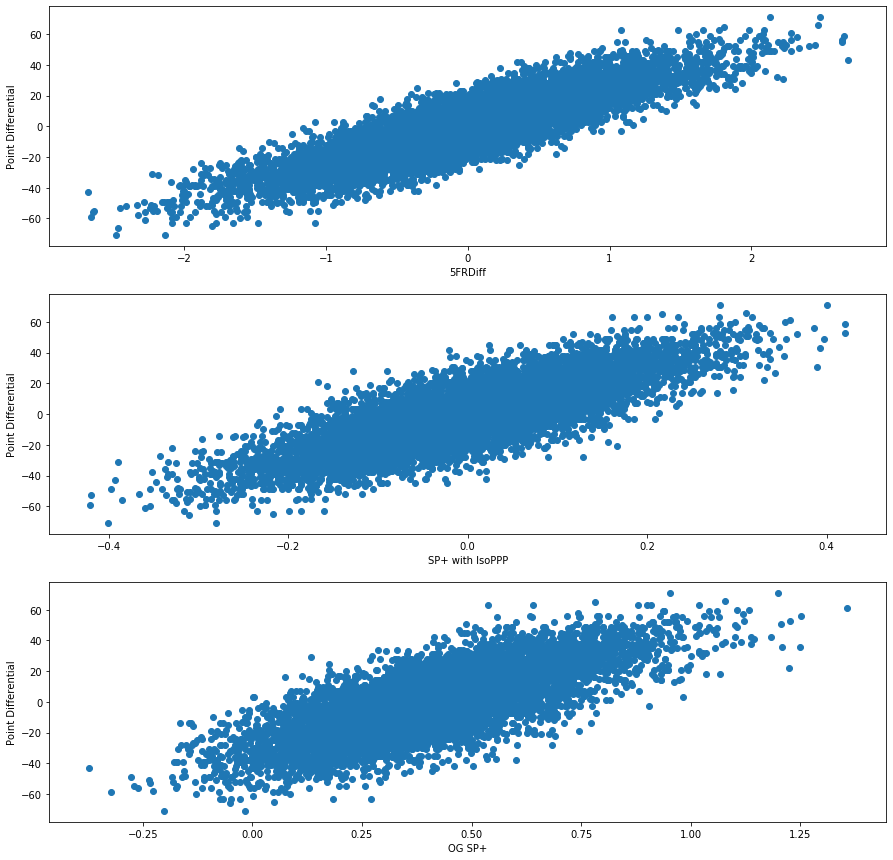

In [904]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("SP+ with IsoPPP")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("OG SP+")
axes[2].set_ylabel("Point Differential");

In [905]:
fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
fg.update_layout(
    title="5FR Margin vs Point Margin (2012-2019)",
    xaxis_title="5FR Margin",
    yaxis_title="Point Margin")
fg.show()

In [906]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

OGS&PDiff  S&PIsoPPPDiff   PtsDiff
OGS&PDiff       1.000000       0.905984  0.739098
S&PIsoPPPDiff   0.905984       1.000000  0.799002
PtsDiff         0.739098       0.799002  1.000000

In [907]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0               UCF    2012  322432006  56.0     42.0        0.796214     67   
1             Akron    2012  322432006  14.0    -42.0        0.203786     81   
0    South Carolina    2012  322430238  17.0      4.0        0.518995     62   
1        Vanderbilt    2012  322430238  13.0     -4.0        0.481005     59   
0  Eastern Michigan    2012  322432050  26.0    -11.0        0.020080     67   

      OffSR     OffER       YPP  ...  PuntEqPPPDiff  PuntIsoPPPDiff  \
0  0.492537  0.074627  6.029851  ...       4.968386        4.842944   
1  0.382716  0.061728  4.370370  ...      -4.968386       -4.842944   
0  0.435484  0.080645  5.129032  ...       3.471563        2.354973   
1  0.271186  0.152542  5.813559  ...      -3.471563       -2.354973   
0  0.447761  0.134328  6.119403  ...       3.498718        3.709156   

   KickoffReturnEqPPPDiff  KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  \
0                4.629272                 4.134715             4.968386   
1               -4.629272                -4.134715            -4.968386   
0                0.969049                 1.381137             3.471563   
1               -0.969049                -1.381137            -3.471563   
0                1.714467                 1.340515             3.498718   

   PuntReturnIsoPPPDiff       5FR   5FRDiff  5fr_z_score  pts_z_score  
0              4.842944  5.299075  0.617590     0.844447     2.041125  
1             -4.842944  4.676917 -0.617590     0.844447     2.041125  
0              2.354973  5.290026  0.603619     0.825343     0.194393  
1             -2.354973  4.696047 -0.603619     0.825343     0.194393  
0              3.709156  4.833610 -0.351666     0.480841     0.534580  

[5 rows x 72 columns]

In [908]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.5) | (stored_game_boxes['pts_z_score'] >= 3.5)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.5) & (stored_game_boxes['pts_z_score'] < 3.5)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

# outliers

train_data.head()

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0               UCF    2012  322432006  56.0     42.0        0.796214     67   
1             Akron    2012  322432006  14.0    -42.0        0.203786     81   
0  Eastern Michigan    2012  322432050  26.0    -11.0        0.020080     67   
1        Ball State    2012  322432050  37.0     11.0        0.979920     96   
0              UCLA    2012  322430242  49.0     25.0        0.361313     69   

      OffSR     OffER       YPP  ...  PuntEqPPPDiff  PuntIsoPPPDiff  \
0  0.492537  0.074627  6.029851  ...       4.968386        4.842944   
1  0.382716  0.061728  4.370370  ...      -4.968386       -4.842944   
0  0.447761  0.134328  6.119403  ...       3.498718        3.709156   
1  0.510417  0.083333  6.291667  ...      -3.498718       -3.709156   
0  0.536232  0.130435  9.173913  ...       3.032793        2.977768   

   KickoffReturnEqPPPDiff  KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  \
0                4.629272                 4.134715             4.968386   
1               -4.629272                -4.134715            -4.968386   
0                1.714467                 1.340515             3.498718   
1               -1.714467                -1.340515            -3.498718   
0                1.999817                 1.586675             3.032793   

   PuntReturnIsoPPPDiff       5FR   5FRDiff  5fr_z_score  pts_z_score  
0              4.842944  5.299075  0.617590     0.844447     2.041125  
1             -4.842944  4.676917 -0.617590     0.844447     2.041125  
0              3.709156  4.833610 -0.351666     0.480841     0.534580  
1             -3.709156  5.184116  0.351666     0.480841     0.534580  
0              2.977768  5.307051  0.645248     0.882263     1.214955  

[5 rows x 72 columns]

In [909]:
fgr = px.scatter(train_data, x="5FRDiff", y="PtsDiff", trendline="lowess")
fgr.update_layout(
    title="5FR Margin vs Point Margin (2012-2019)",
    xaxis_title="5FR Margin",
    yaxis_title="Point Margin")
fgr.show()

In [910]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [911]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Linear Regression: y = 24.57570x + -0.10739
Mean Pred Score: 0.2603249095064961
Pred Std Dev: 18.2987347867836
Mean Abs Error: 8.024865006176693
Mdn Abs Error: 6.8677067162341965
R-squared: 0.7686414884700346
Adj R-squared: 0.7685088287730564



ActPtsDiff  OffSRDiff  OffERDiff    FPDiff  \
ActPtsDiff                 1.000000   0.746769   0.574879  0.488877   
OffSRDiff                  0.746769   1.000000   0.445216  0.299692   
OffERDiff                  0.574879   0.445216   1.000000  0.171423   
FPDiff                     0.488877   0.299692   0.171423  1.000000   
OppRateDiff                0.787162   0.682744   0.500245  0.599096   
OppEffDiff                 0.586169   0.350456   0.318248  0.121021   
OppPPDDiff                 0.605212   0.411463   0.348958  0.097621   
PPDDiff                    0.983422   0.738899   0.558425  0.472038   
OppSRDiff                  0.520491   0.749409   0.339322  0.070906   
YPPDiff                    0.779567   0.701171   0.797370  0.242092   
ExpTODiff                 -0.478957  -0.308661  -0.220328 -0.304881   
ActualTODiff              -0.480951  -0.186600  -0.132579 -0.378041   
AvgEqPPPDiff               0.735445   0.632930   0.746727  0.226217   
TotalEqPPPDiff             0.748701   0.748195   0.594287  0.212760   
IsoPPPDiff                 0.243094  -0.088307   0.563006  0.012363   
HavocRateDiff              0.549465   0.534818   0.178227  0.272504   
SackRateDiff               0.494998   0.456957   0.221620  0.280697   
KickoffSRDiff              0.055381   0.006138   0.011046  0.250934   
KickoffReturnSRDiff        0.052929  -0.001665  -0.010344  0.202087   
PuntSRDiff                 0.179020   0.115308   0.101808  0.226630   
PuntReturnSRDiff           0.179020   0.115308   0.101808  0.226630   
FGEffDiff                  0.166623   0.075667   0.081976  0.164422   
KickoffEqPPPDiff          -0.147912  -0.137614  -0.099780 -0.004082   
KickoffIsoPPPDiff         -0.171717  -0.141461  -0.103503 -0.057251   
PuntEqPPPDiff             -0.171666  -0.141544  -0.094300 -0.062529   
PuntIsoPPPDiff            -0.185067  -0.160432  -0.109163 -0.085165   
KickoffReturnEqPPPDiff    -0.147912  -0.137614  -0.099780 -0.004082   
KickoffReturnIsoPPPDiff   -0.171717  -0.141461  -0.103503 -0.057251   
PuntReturnEqPPPDiff       -0.171666  -0.141544  -0.094300 -0.062529   
PuntReturnIsoPPPDiff      -0.185067  -0.160432  -0.109163 -0.085165   
5FR                        0.868305   0.957404   0.528890  0.377505   
5FRDiff                    0.877132   0.951098   0.526075  0.390173   
PredPtsDiff                0.877132   0.951098   0.526075  0.390173   

                         OppRateDiff  OppEffDiff  OppPPDDiff   PPDDiff  \
ActPtsDiff                  0.787162    0.586169    0.605212  0.983422   
OffSRDiff                   0.682744    0.350456    0.411463  0.738899   
OffERDiff                   0.500245    0.318248    0.348958  0.558425   
FPDiff                      0.599096    0.121021    0.097621  0.472038   
OppRateDiff                 1.000000    0.172762    0.184117  0.784523   
OppEffDiff                  0.172762    1.000000    0.739918  0.579465   
OppPPDDiff                  0.184117    0.739918    1.000000  0.607425   
PPDDiff                     0.784523    0.579465    0.607425  1.000000   
OppSRDiff                   0.268168    0.465624    0.545694  0.511225   
YPPDiff                     0.662850    0.418698    0.477061  0.762352   
ExpTODiff                  -0.344098   -0.303209   -0.315792 -0.469433   
ActualTODiff               -0.334640   -0.346707   -0.324748 -0.478889   
AvgEqPPPDiff                0.589631    0.400825    0.456875  0.718851   
TotalEqPPPDiff              0.728924    0.340576    0.359785  0.721708   
IsoPPPDiff                  0.131103    0.194312    0.206029  0.231430   
HavocRateDiff               0.503869    0.306282    0.328425  0.556972   
SackRateDiff                0.448655    0.258048    0.299106  0.491895   
KickoffSRDiff               0.088079   -0.049638   -0.008947  0.052771   
KickoffReturnSRDiff         0.067675   -0.024810   -0.005784  0.052427   
PuntSRDiff                  0.200887    0.062593    0.045160  0.193333   
PuntReturnSRDiff            0.200887    0.062593    0.04

In [912]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

ActPtsDiff    ActPts       Eff      Expl    FinDrv    FldPos  \
ActPtsDiff     1.000000  0.760765  0.746769  0.735445  0.905619  0.482239   
ActPts         0.760765  1.000000  0.570563  0.558880  0.681260  0.594749   
Eff            0.746769  0.570563  1.000000  0.632930  0.783586  0.716178   
Expl           0.735445  0.558880  0.632930  1.000000  0.703892  0.435496   
FinDrv         0.905619  0.681260  0.783586  0.703892  1.000000  0.507613   
FldPos         0.482239  0.594749  0.716178  0.435496  0.507613  1.000000   
Trnovr         0.465523  0.365163  0.314825  0.259594  0.429240  0.110234   
5FR            0.868305  0.661539  0.957404  0.725140  0.917418  0.655741   
5FRDiff        0.877132  0.666561  0.951098  0.723653  0.922445  0.644862   
PredPtsDiff    0.877132  0.666561  0.951098  0.723653  0.922445  0.644862   

               Trnovr       5FR   5FRDiff  PredPtsDiff  
ActPtsDiff   0.465523  0.868305  0.877132     0.877132  
ActPts       0.365163  0.661539  0.666561     0.666561  
Eff          0.314825  0.957404  0.951098     0.951098  
Expl         0.259594  0.725140  0.723653     0.723653  
FinDrv       0.429240  0.917418  0.922445     0.922445  
FldPos       0.110234  0.655741  0.644862     0.644862  
Trnovr       1.000000  0.464619  0.448154     0.448154  
5FR          0.464619  1.000000  0.996011     0.996011  
5FRDiff      0.448154  0.996011  1.000000     1.000000  
PredPtsDiff  0.448154  0.996011  1.000000     1.000000

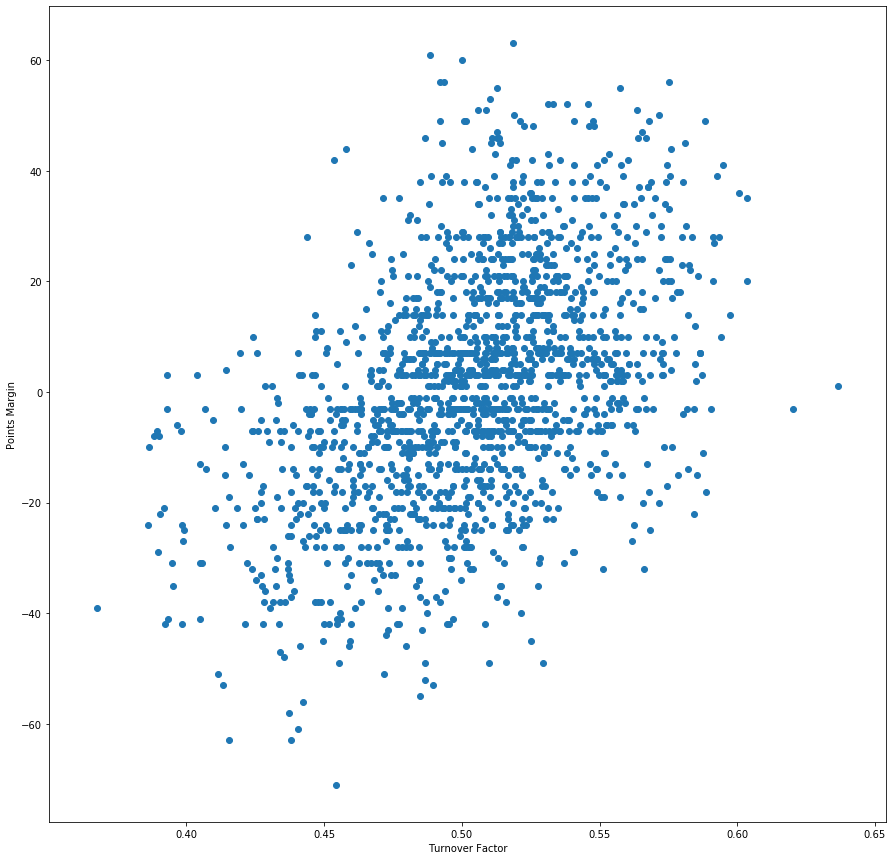

In [913]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

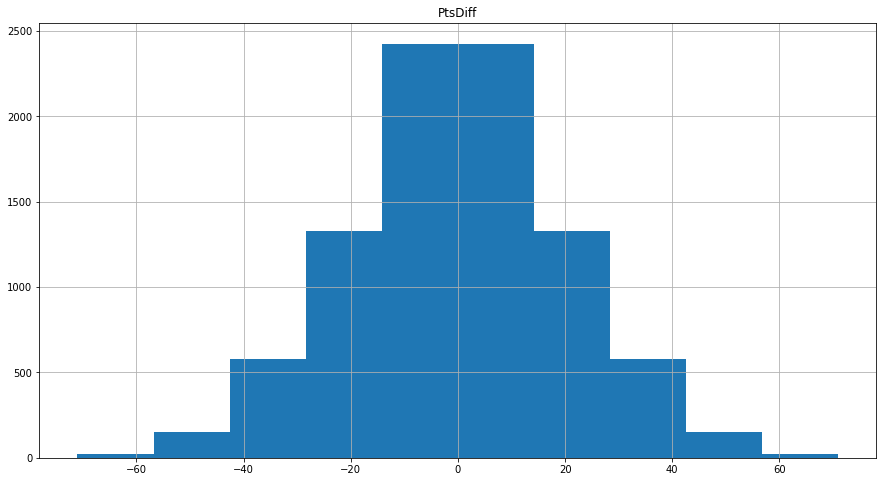

In [914]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

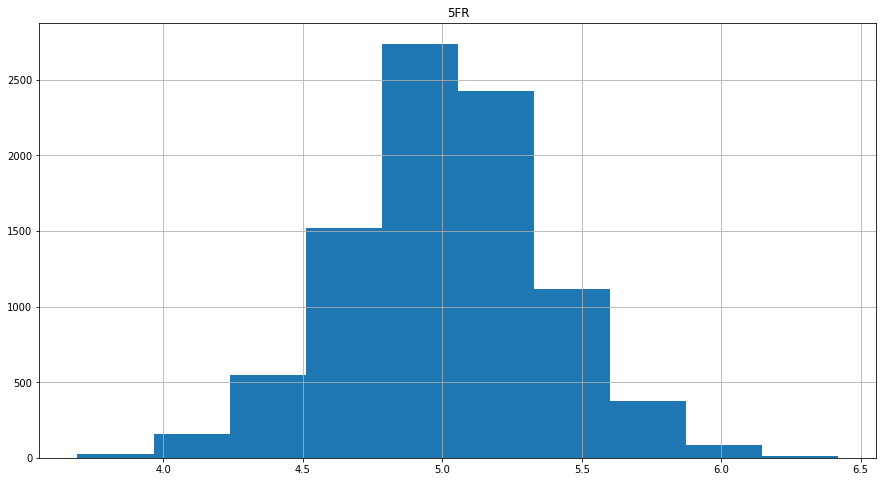

In [915]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

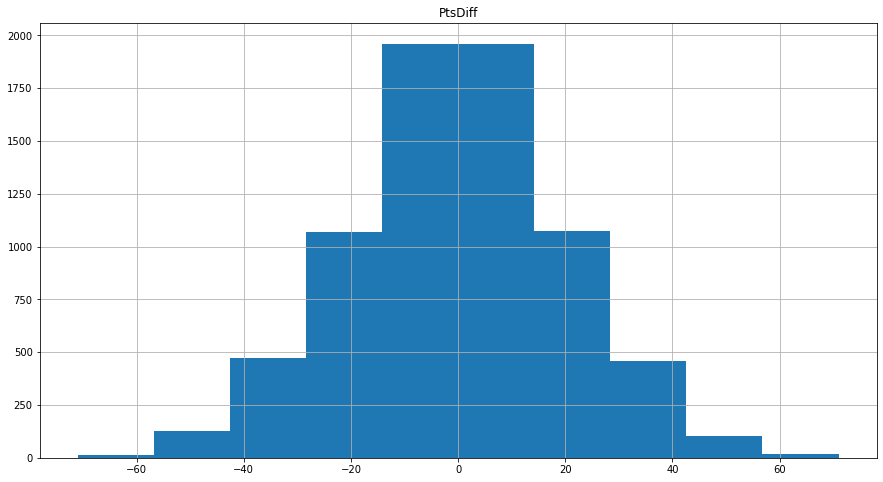

In [916]:
train_data.hist(column='PtsDiff', figsize=(15,8));

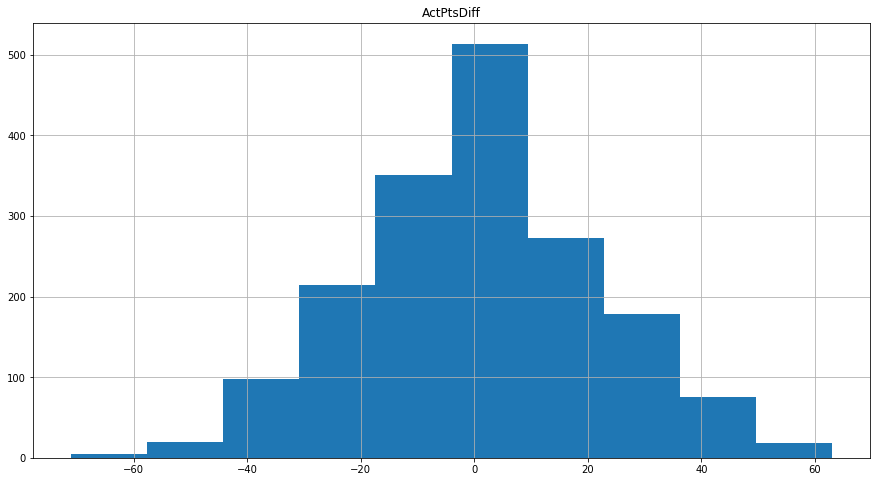

In [917]:
test.hist(column='ActPtsDiff', figsize=(15,8));

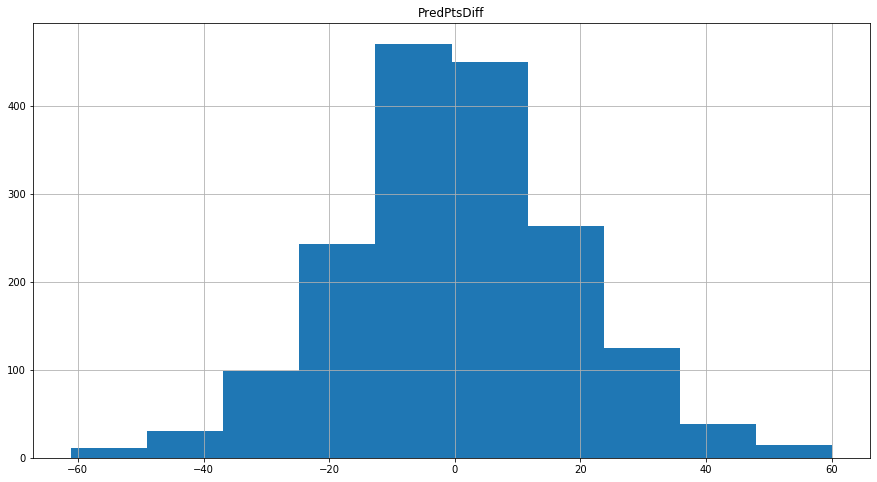

In [918]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [919]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [920]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -5.0 (exact value: -5.163176318612343)
Z score: -0.2963866787137657
Win Prob for Virginia Tech: 38.35%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0       Virginia    2018  401013183  31.0     -3.0        0.875665     63   
1  Virginia Tech    2018  401013183  34.0      3.0        0.124335     76   

      OffSR     OffER       YPP  ...  KickoffEqPPPDiff  KickoffIsoPPPDiff  \
0  0.396825  0.111111  6.507937  ...         -1.519733          -1.519733   
1  0.368421  0.078947  5.513158  ...          1.519733           1.519733   

   PuntEqPPPDiff  PuntIsoPPPDiff  KickoffReturnEqPPPDiff  \
0      -0.213025          0.5748                1.519733   
1       0.213025         -0.5748               -1.519733   

   KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  PuntReturnIsoPPPDiff  \
0                 1.519733            -0.213025                0.5748   
1                -1.519733             0.213025               -0.5748   

        5FR   5FRDiff  
0  5.109326  0.205723  
1  4.903603 -0.205723  

[2 rows x 70 columns]

In [921]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -1.0 (exact value: -1.239627633289657)
Z score: -0.08197028703205782
Win Prob for Georgia Tech: 46.73%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0  Georgia Tech    2019  401112488  28.0      7.0        0.065752     63   
1         Miami    2019  401112488  21.0     -7.0        0.934248     62   

      OffSR     OffER       YPP  ...  KickoffEqPPPDiff  KickoffIsoPPPDiff  \
0  0.396825  0.111111  5.460317  ...         -1.081912          -2.006527   
1  0.370968  0.112903  5.790323  ...          1.081912           2.006527   

   PuntEqPPPDiff  PuntIsoPPPDiff  KickoffReturnEqPPPDiff  \
0      -1.198533       -1.604158                1.081912   
1       1.198533        1.604158               -1.081912   

   KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  PuntReturnIsoPPPDiff  \
0                 2.006527            -1.198533             -1.604158   
1                -2.006527             1.198533              1.604158   

        5FR   5FRDiff  
0  5.006865 -0.046072  
1  5.052937  0.046072  

[2 rows x 70 columns]

In [922]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -2.0 (exact value: -1.6315181387648054)
Z score: -0.10338654941530162
Win Prob for Georgia Tech: 45.88%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0      NC State    2019  401112513  26.0     -2.0        0.156447     80   
1  Georgia Tech    2019  401112513  28.0      2.0        0.843553     57   

      OffSR     OffER       YPP  ...  KickoffEqPPPDiff  KickoffIsoPPPDiff  \
0  0.487500  0.150000  5.712500  ...         -0.980216          -0.738284   
1  0.473684  0.140351  7.035088  ...          0.980216           0.738284   

   PuntEqPPPDiff  PuntIsoPPPDiff  KickoffReturnEqPPPDiff  \
0      -0.222096       -0.222096                0.980216   
1       0.222096        0.222096               -0.980216   

   KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  PuntReturnIsoPPPDiff  \
0                 0.738284            -0.222096             -0.222096   
1                -0.738284             0.222096              0.222096   

        5FR   5FRDiff  
0  5.039353  0.062018  
1  4.977335 -0.062018  

[2 rows x 70 columns]

In [923]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 1.0 (exact value: 0.872335812721566)
Z score: 0.033445531089783286
Win Prob for Mississippi State: 51.33%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0           Ole Miss    2019  401110863  20.0     -1.0        0.384124     71   
1  Mississippi State    2019  401110863  21.0      1.0        0.615876     58   

      OffSR     OffER       YPP  ...  KickoffEqPPPDiff  KickoffIsoPPPDiff  \
0  0.422535  0.070423  5.563380  ...         -1.092153          -1.073105   
1  0.413793  0.137931  5.482759  ...          1.092153           1.073105   

   PuntEqPPPDiff  PuntIsoPPPDiff  KickoffReturnEqPPPDiff  \
0       1.381978        1.674666                1.092153   
1      -1.381978       -1.674666               -1.092153   

   KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  PuntReturnIsoPPPDiff  \
0                 1.073105             1.381978              1.674666   
1                -1.073105            -1.381978             -1.674666   

        5FR   5FRDiff  
0  4.975487 -0.039865  
1  5.015352  0.039865  

[2 rows x 70 columns]

In [924]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -4.0 (exact value: -3.510635012568915)
Z score: -0.2060776313780456
Win Prob for Texas A&M: 41.84%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0        LSU    2018  401012356  72.0     -2.0        0.321374     90   
1  Texas A&M    2018  401012356  74.0      2.0        0.678626    104   

      OffSR     OffER       YPP  ...  KickoffEqPPPDiff  KickoffIsoPPPDiff  \
0  0.466667  0.088889  5.511111  ...         -1.439296          -1.500023   
1  0.423077  0.105769  4.634615  ...          1.439296           1.500023   

   PuntEqPPPDiff  PuntIsoPPPDiff  KickoffReturnEqPPPDiff  \
0       1.105475        1.785905                1.439296   
1      -1.105475       -1.785905               -1.439296   

   KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  PuntReturnIsoPPPDiff  \
0                 1.500023             1.105475              1.785905   
1                -1.500023            -1.105475             -1.785905   

        5FR  5FRDiff  
0  5.077162  0.13848  
1  4.938682 -0.13848  

[2 rows x 70 columns]

In [925]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

team  avg_win_prob  games  proj_wins  proj_losses
1           Ohio State      0.943593     13       12.0          1.0
2                  LSU      0.937281     13       12.0          1.0
3              Alabama      0.912159     12       11.0          1.0
4             Oklahoma      0.878947     13       11.0          2.0
5              Clemson      0.877127     13       11.0          2.0
6                 Navy      0.835777     12       10.0          2.0
7                 Utah      0.832000     13       11.0          2.0
8              Buffalo      0.814669     12       10.0          2.0
9               Oregon      0.805389     13       10.0          3.0
10           Minnesota      0.798064     12       10.0          2.0
11           Air Force      0.789600     13       10.0          3.0
12             Georgia      0.771500     13       10.0          3.0
13          Penn State      0.756229     12        9.0          3.0
14   Appalachian State      0.755588     13       10.0          3.0
15             Memphis      0.748167     13       10.0          3.0
16                 UCF      0.743215     12        9.0          3.0
17            Michigan      0.721558     12        9.0          3.0
18              Baylor      0.699799     13        9.0          4.0
19           Wisconsin      0.696557     13        9.0          4.0
20             Florida      0.696198     12        8.0          4.0
21    Central Michigan      0.694922     13        9.0          4.0
22    Florida Atlantic      0.684497     13        9.0          4.0
23          Notre Dame      0.674173     12        8.0          4.0
24           Texas A&M      0.674114     12        8.0          4.0
25         Boise State      0.644921     13        8.0          5.0
26           Louisiana      0.644585     13        8.0          5.0
27          Cincinnati      0.643945     13        8.0          5.0
28      Louisiana Tech      0.639118     12        8.0          4.0
29                Ohio      0.630640     12        8.0          4.0
30               Miami      0.627412     12        8.0          4.0
..                 ...           ...    ...        ...          ...
101         California      0.313277     12        4.0          8.0
102             Toledo      0.310753     12        4.0          8.0
103               UCLA      0.309037     12        4.0          8.0
104       Georgia Tech      0.306654     12        4.0          8.0
105             Nevada      0.299188     12        4.0          8.0
106            Arizona      0.298543     12        4.0          8.0
107      Georgia State      0.294141     12        4.0          8.0
108               Rice      0.282356     12        3.0          9.0
109           Colorado      0.273724     12        3.0          9.0
110     UT San Antonio      0.272369     12        3.0          9.0
111         New Mexico      0.266518     13        3.0         10.0
112               UTEP      0.249820     12        3.0          9.0
113               UNLV      0.232954     12        3.0          9.0
114         Utah State      0.230856     12        3.0          9.0
115           Arkansas      0.229139     12        3.0          9.0
116      West Virginia      0.214624     12        3.0          9.0
117      East Carolina      0.211350     12        3.0          9.0
118       Old Dominion      0.210176     12        3.0          9.0
119         Miami (OH)      0.207585     13        3.0         10.0
120             Kansas      0.204714     12        2.0         10.0
121      South Florida      0.183808     12        2.0         10.0
122        Texas State      0.149057     12        2.0         10.0
123   New Mexico State      0.140518     12        2.0         10.0
124      Bowling Green      0.128227     12        2.0         10.0
125        Connecticut      0.125743     12        2.0         10.0
126         Vanderbilt      0.123211     12        1.0         11.0
127              Akron      0.074927     12        1.0         11.0
128   

In [926]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

team  second_order_wins  second_order_losses
77          Ohio State          10.583971             2.416029
53                 LSU           9.797094             3.202906
78            Oklahoma           8.889853             4.110147
115               Utah           8.193907             4.806093
34             Georgia           7.471560             5.528440
11              Baylor           7.235142             5.764858
82              Oregon           7.119397             5.880603
3    Appalachian State           7.055202             5.944798
56             Memphis           7.022200             5.977800
91                 SMU           6.718674             5.281326
30    Florida Atlantic           6.551310             6.448690
59            Michigan           6.538454             5.461546
60      Michigan State           6.365688             5.634312
99              Temple           6.341616             5.658384
110                UCF           6.324994             5.675006
75          Notre Dame           6.324812             5.675188
102          Texas A&M           6.309857             5.690143
12         Boise State           6.258336             6.741664
29             Florida           6.250180             5.749820
101              Texas           6.248623             5.751377
98                 TCU           6.172478             5.827522
57               Miami           6.113905             5.886095
125   Western Kentucky           6.090988             5.909012
129            Wyoming           6.067904             5.932096
109                UAB           6.042395             6.957605
15             Buffalo           6.020205             5.979795
64            Missouri           5.993808             6.006192
85          Pittsburgh           5.942609             6.057391
122        Wake Forest           5.807741             6.192259
21             Clemson           5.774055             7.225945
..                 ...                ...                  ...
4              Arizona           3.191893             8.808107
44              Kansas           3.166994             8.833006
127      West Virginia           3.150859             8.849141
118     UT San Antonio           3.091646             8.908354
96            Stanford           3.037163             8.962837
120           Virginia           3.029867             9.970133
74        Northwestern           3.029069             8.970931
95       South Florida           2.981426             9.018574
69          New Mexico           2.952101            10.047899
116         Utah State           2.914493             9.085507
61    Middle Tennessee           2.811439             9.188561
6             Arkansas           2.808036             9.191964
17          California           2.738539             9.261461
117               UTEP           2.678595             9.321405
27       East Carolina           2.620147             9.379853
37        Georgia Tech           2.614273             9.385727
58          Miami (OH)           2.588081            10.411919
92       South Alabama           2.431408             9.568592
113               UNLV           2.127353             9.872647
80        Old Dominion           2.098758             9.901242
36       Georgia State           1.952170            10.047830
103        Texas State           1.763739            10.236261
25         Connecticut           1.661682            10.338318
119         Vanderbilt           1.643056            10.356944
70    New Mexico State           1.605407            10.394593
1                Akron           1.396407            10.603593
55            Maryland           1.188318            10.811682
14       Bowling Green           1.149689            10.850311
88             Rutgers           0.767338            11.232662
112              UMass           0.540403            11.459597

[130 rows x 3 columns]

In [927]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

Team  Season       5FR  Rank
0         Florida State    2012  5.464065     1
1         Arizona State    2012  5.340703     2
2               Alabama    2012  5.288094     3
3           Boise State    2012  5.285045     4
4               Georgia    2012  5.255023     5
5          Fresno State    2012  5.253560     6
6              Oklahoma    2012  5.253433     7
7            Ohio State    2012  5.221638     8
8         Bowling Green    2012  5.217117     9
9        Michigan State    2012  5.194738    10
10    Northern Illinois    2012  5.191385    11
11               Nevada    2012  5.185692    12
12       North Carolina    2012  5.182557    13
13           Utah State    2012  5.181204    14
14           Notre Dame    2012  5.175030    15
15                  BYU    2012  5.173907    16
16                Texas    2012  5.173346    17
17                Tulsa    2012  5.161676    18
18                 UCLA    2012  5.155218    19
19              Clemson    2012  5.140047    20
20            Wisconsin    2012  5.134379    21
21    Appalachian State    2012  5.128731    22
22             Nebraska    2012  5.119657    23
23            Texas A&M    2012  5.114303    24
24           Louisville    2012  5.101662    25
25           Penn State    2012  5.098342    26
26                  UCF    2012  5.096517    27
27                  LSU    2012  5.096175    28
28         Oregon State    2012  5.095690    29
29       Oklahoma State    2012  5.094236    30
...                 ...     ...       ...   ...
996             Houston    2019  4.852194   101
997        Northwestern    2019  4.849169   102
998        Georgia Tech    2019  4.845097   103
999                UCLA    2019  4.844909   104
1000             Nevada    2019  4.842289   105
1001      Georgia State    2019  4.827581   106
1002               Rice    2019  4.827453   107
1003         New Mexico    2019  4.818727   108
1004            Arizona    2019  4.815414   109
1005     UT San Antonio    2019  4.810442   110
1006           Colorado    2019  4.789962   111
1007               UTEP    2019  4.769385   112
1008               UNLV    2019  4.766720   113
1009           Arkansas    2019  4.746052   114
1010         Utah State    2019  4.744859   115
1011      West Virginia    2019  4.732818   116
1012      East Carolina    2019  4.730601   117
1013       Old Dominion    2019  4.729832   118
1014             Kansas    2019  4.723853   119
1015         Miami (OH)    2019  4.723660   120
1016      South Florida    2019  4.686318   121
1017   New Mexico State    2019  4.632016   122
1018        Texas State    2019  4.626952   123
1019      Bowling Green    2019  4.619195   124
1020        Connecticut    2019  4.594926   125
1021         Vanderbilt    2019  4.587212   126
1022              Akron    2019  4.502711   127
1023           Maryland    2019  4.449797   128
1024            Rutgers    2019  4.405016   129
1025              UMass    2019  4.310881   130

[1026 rows x 4 columns]

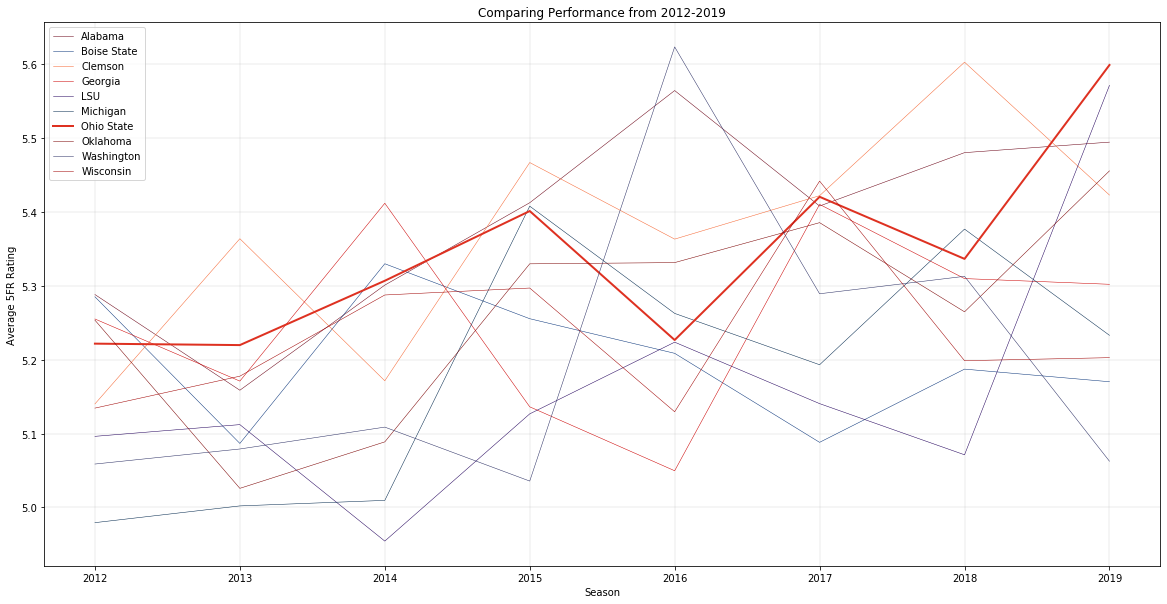

In [928]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [929]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

Team    Avg5FR
0              Alabama  5.388319
1              Clemson  5.369025
2           Ohio State  5.341411
3             Oklahoma  5.266815
4              Georgia  5.255640
5            Wisconsin  5.233589
6          Boise State  5.201330
7           Washington  5.196216
8     Western Kentucky  5.192134
9             Michigan  5.182976
10       Florida State  5.171597
11      Michigan State  5.170725
12                 LSU  5.161968
13   Appalachian State  5.157436
14              Baylor  5.154428
15                 TCU  5.148112
16          Penn State  5.145952
17              Oregon  5.142810
18          Notre Dame  5.141259
19   Mississippi State  5.121561
20                 USC  5.117710
21       Virginia Tech  5.115931
22           Air Force  5.109874
23             Florida  5.107829
24          Louisville  5.107319
25          Cincinnati  5.106169
26                 UCF  5.105208
27      Arkansas State  5.099170
28            Marshall  5.097815
29                Ohio  5.093103
..                 ...       ...
100           Colorado  4.890591
101            Hawai'i  4.889668
102   Louisiana Monroe  4.888965
103             Tulane  4.882576
104             Purdue  4.882444
105        Wake Forest  4.879672
106      Georgia State  4.876925
107       Oregon State  4.871789
108   Coastal Carolina  4.867144
109               UNLV  4.866106
110           Kentucky  4.862636
111               Rice  4.854803
112         Miami (OH)  4.854054
113         New Mexico  4.848387
114                SMU  4.848104
115         Kent State  4.847065
116       Old Dominion  4.842271
117   Eastern Michigan  4.841847
118           Illinois  4.838777
119     San José State  4.835585
120              Akron  4.808679
121          Charlotte  4.808502
122           Maryland  4.799320
123        Connecticut  4.797840
124               UTEP  4.794005
125        Texas State  4.789825
126            Rutgers  4.788842
127              UMass  4.764287
128   New Mexico State  4.748899
129             Kansas  4.674455

[130 rows x 2 columns]

In [930]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

Team  Season       5FR  Rank
508     Washington    2016  5.623271     1
766        Clemson    2018  5.602589     1
896     Ohio State    2019  5.598777     1
125  Florida State    2013  5.590725     1
897            LSU    2019  5.571245     2
509        Alabama    2016  5.564191     2
510     Louisville    2016  5.511334     3
898        Alabama    2019  5.494394     3
767       NC State    2018  5.494245     2
768        Alabama    2018  5.480164     3

In [931]:
strength_max[strength_max.Team == "Georgia Tech"]

Team  Season       5FR  Rank
285  Georgia Tech    2014  5.129904    34
695  Georgia Tech    2017  5.043774    60
63   Georgia Tech    2012  4.995567    64
186  Georgia Tech    2013  4.981889    62
582  Georgia Tech    2016  4.958749    75
467  Georgia Tech    2015  4.892918    88
998  Georgia Tech    2019  4.845097   103
880  Georgia Tech    2018  4.754394   115

In [932]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

GameID          Opponent  Season       Team  Week
0     322520130.0          Michigan  2012.0  Air Force   1.0
1     322662439.0              UNLV  2012.0  Air Force   2.0
2     322732005.0    Colorado State  2012.0  Air Force   3.0
3     322872751.0           Wyoming  2012.0  Air Force   4.0
4     322942005.0        New Mexico  2012.0  Air Force   5.0
5     323290278.0      Fresno State  2012.0  Air Force   6.0
6     332502005.0        Utah State  2013.0  Air Force   1.0
7     332642005.0           Wyoming  2013.0  Air Force   2.0
8     332712440.0            Nevada  2013.0  Air Force   3.0
9     332782426.0              Navy  2013.0  Air Force   4.0
10    332832005.0   San Diego State  2013.0  Air Force   5.0
11    332992005.0        Notre Dame  2013.0  Air Force   6.0
12    333062005.0              Army  2013.0  Air Force   7.0
13    333340036.0    Colorado State  2013.0  Air Force   8.0
14    400548180.0           Wyoming  2014.0  Air Force   1.0
15    400548189.0     Georgia State  2014.0  Air Force   2.0
16    400548199.0       Boise State  2014.0  Air Force   3.0
17    400548205.0              Navy  2014.0  Air Force   4.0
18    400548210.0        Utah State  2014.0  Air Force   5.0
19    400548215.0        New Mexico  2014.0  Air Force   6.0
20    400548232.0              UNLV  2014.0  Air Force   7.0
21    400548249.0    Colorado State  2014.0  Air Force   8.0
22    400787117.0    San José State  2015.0  Air Force   1.0
23    400764876.0              Navy  2015.0  Air Force   2.0
24    400787254.0           Wyoming  2015.0  Air Force   3.0
25    400787266.0      Fresno State  2015.0  Air Force   4.0
26    400787271.0           Hawai'i  2015.0  Air Force   5.0
27    400760497.0              Army  2015.0  Air Force   6.0
28    400787280.0        Utah State  2015.0  Air Force   7.0
29    400790881.0       Boise State  2015.0  Air Force   8.0
...           ...               ...     ...        ...   ...
8978  400869250.0   San Diego State  2016.0    Wyoming   9.0
8979  400869254.0        New Mexico  2016.0    Wyoming  10.0
8980  400926949.0   San Diego State  2016.0    Wyoming  11.0
8981  400944845.0       Texas State  2017.0    Wyoming   1.0
8982  400945276.0        Utah State  2017.0    Wyoming   2.0
8983  400945285.0        New Mexico  2017.0    Wyoming   3.0
8984  400945290.0    Colorado State  2017.0    Wyoming   4.0
8985  400945295.0         Air Force  2017.0    Wyoming   5.0
8986  400945304.0      Fresno State  2017.0    Wyoming   6.0
8987  400945309.0    San José State  2017.0    Wyoming   7.0
8988  401013437.0  New Mexico State  2018.0    Wyoming   1.0
8989  401012683.0  Washington State  2018.0    Wyoming   2.0
8990  401012267.0          Missouri  2018.0    Wyoming   3.0
8991  401022526.0       Boise State  2018.0    Wyoming   4.0
8992  401022531.0           Hawai'i  2018.0    Wyoming   5.0
8993  401022537.0      Fresno State  2018.0    Wyoming   6.0
8994  401022540.0        Utah State  2018.0    Wyoming   7.0
8995  401022546.0    Colorado State  2018.0    Wyoming   8.0
8996  401022552.0    San José State  2018.0    Wyoming   9.0
8997  401022567.0        New Mexico  2018.0    Wyoming  10.0
8998  401110728.0          Missouri  2019.0    Wyoming   1.0
8999  401117500.0       Texas State  2019.0    Wyoming   2.0
9000  401117509.0             Tulsa  2019.0    Wyoming   3.0
9001  401117514.0              UNLV  2019.0    Wyoming   4.0
9002  401117523.0   San Diego State  2019.0    Wyoming   5.0
9003  401117526.0        New Mexico  2019.0    Wyoming   6.0
9004  401117533.0            Nevada  2019.0    Wyoming   7.0
9005  401117541.0       Boise State  2019.0    Wyoming   8.0
9006  401117546.0        Utah State  2019.0    Wyoming   9.0
9007  401117550.0    Colorado State  2019.0    Wyoming  10.0

[9008 rows x 5 columns]

In [933]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week) & (opponent_game_ids.Season == year)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week) & (opponent_game_ids.Season == year)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += 2.5
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.24289306636461527, -12.494380406574917]

In [934]:
team_triples = [
    ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
    ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
    ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
    ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
    ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
    ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
    ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
    ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
    ['UCF','Marshall',15,23], # UCF 48, Marshall 25
    ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
    ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
    ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
    ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
    ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
    ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
    ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
    ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
    ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
    ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
    ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
    ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
    ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
    ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
    ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
    ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
    ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
    ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
#    ----- 19-8 SU / 14-13 ATS ------  
    ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
#    ----- 20-8 SU / 15-13 ATS ------  
    ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
#    ----- 21-8 SU / 15-14 ATS ------  
    ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
    ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
    ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
    ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
    ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
    ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
    ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
    ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6, 17]
#    ----- 24-16 SU / 19-21 ATS ------  
]

def determine_ml_base_win(row):
    winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

def determine_ats_base_win(row):
    mov = row.home_point_diff
    if (row.spread > 0):
        if (mov == row.spread):
            return "Push"
        winner = row.favorite if (mov > row.spread) else row.opponent
    elif (row.spread < 0):
        if (mov == row.spread):
            return "Push"
        winner = row.opponent if (mov < row.spread) else row.favorite
    else:
        winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    point_diff = data[3]
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "home_point_diff" : [point_diff],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

favorite              opponent  spread  home_point_diff  \
0                Buffalo             Charlotte     7.0               24   
0             Utah State            Kent State     7.0              -10   
0        San Diego State      Central Michigan     3.5               37   
0       Georgia Southern               Liberty     4.5               -7   
0                    SMU      Florida Atlantic     7.0              -14   
0  Florida International        Arkansas State     1.0               -6   
0             Washington           Boise State     3.5               31   
0      Appalachian State                   UAB    17.0               14   
0                    UCF              Marshall    15.0               23   
0                    BYU               Hawai'i     2.0               -4   
0                  Miami        Louisiana Tech     6.0              -14   
0             Pittsburgh      Eastern Michigan    11.0                4   
0         North Carolina                Temple     5.0               42   
0         Michigan State           Wake Forest     3.5                6   
0              Texas A&M        Oklahoma State     7.0                3   
0                   Iowa                   USC     2.5               24   
0              Air Force      Washington State     3.0               10   
0             Penn State               Memphis     7.0               14   
0             Notre Dame            Iowa State     4.0               24   
0                    LSU              Oklahoma    11.0               35   
0                Clemson            Ohio State     2.5                6   
0       Western Kentucky      Western Michigan     3.5                3   
0      Mississippi State            Louisville     4.0              -10   
0             California              Illinois     6.5               15   
0                Florida              Virginia    14.0                8   
0          Virginia Tech              Kentucky     3.0               -7   
0          Arizona State         Florida State     4.0                6   
0                   Navy          Kansas State     2.0                3   
0                Wyoming         Georgia State     7.0               21   
0                   Utah                 Texas     7.0              -18   
0                 Auburn             Minnesota     7.5               -7   
0                Alabama              Michigan     7.0               19   
0              Wisconsin                Oregon     2.5               -1   
0                Georgia                Baylor     7.5               12   
0             Cincinnati        Boston College     7.0               32   
0              Tennessee               Indiana     1.5                1   
0                   Ohio                Nevada     7.5                8   
0                 Tulane  Southern Mississippi     7.0               17   
0              Louisiana            Miami (OH)    14.0               10   
0                    LSU               Clemson     6.0               17   

    proj_MOV  proj_win_prob  proj_cover_status            ml_pick  \
0   6.215906       0.627585              False            Buffalo   
0   3.721264       0.575007              False         Utah State   
0  -4.546807       0.396390              False   Central Michigan   
0   4.083004       0.582738              False   Georgia Southern   
0 -10.308638       0.281774              False   Florida Atlantic   
0  -5.687945       0.372566              False     Arkansas State   
0  -0.909245       0.474519              False        Boise State   
0   7.519551       0.654208              False  Appalachian State   
0   7.276706       0.649301              False                UCF   
0  -1.493030       0.461832              False            Hawai'i   
0   6.283842       0.628989               True              Miami   
0   2.492364       0.548542              False         Pittsburgh   
0   0.342807       0.501798              Fa

In [935]:
print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

ATS Record: 20-20
ML Record: 27-13


In [936]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 1.0 (exact value: 1.1475085575483004)
Z score: 0.04848333277569438
Win Prob for Virginia: 51.93%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0  Virginia Tech    2019  401112521  30.0     -9.0        0.577256     74   
1       Virginia    2019  401112521  39.0      9.0        0.422744     55   

      OffSR     OffER       YPP  ...  KickoffEqPPPDiff  KickoffIsoPPPDiff  \
0  0.432432  0.162162  6.540541  ...          -0.58366          -1.085661   
1  0.381818  0.181818  8.872727  ...           0.58366           1.085661   

   PuntEqPPPDiff  PuntIsoPPPDiff  KickoffReturnEqPPPDiff  \
0       1.860958        1.493764                 0.58366   
1      -1.860958       -1.493764                -0.58366   

   KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  PuntReturnIsoPPPDiff  \
0                 1.085661             1.860958              1.493764   
1                -1.085661            -1.860958             -1.493764   

        5FR   5FRDiff  
0  4.961527 -0.051062  
1  5.012589  0.051062  

[2 rows x 70 columns]

In [937]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 9.0 (exact value: 8.89314183346051)
Z score: 0.4717712467306281
Win Prob for North Carolina: 68.15%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0  North Carolina    2019  401112475  38.0     16.0         0.98905     94   
1    Georgia Tech    2019  401112475  22.0    -16.0         0.01095     53   

      OffSR     OffER       YPP  ...  KickoffEqPPPDiff  KickoffIsoPPPDiff  \
0  0.457447  0.106383  5.744681  ...         -1.064323          -1.518236   
1  0.396226  0.150943  6.094340  ...          1.064323           1.518236   

   PuntEqPPPDiff  PuntIsoPPPDiff  KickoffReturnEqPPPDiff  \
0       0.735733        1.773056                1.064323   
1      -0.735733       -1.773056               -1.064323   

   KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  PuntReturnIsoPPPDiff  \
0                 1.518236             0.735733              1.773056   
1                -1.518236            -0.735733             -1.773056   

        5FR   5FRDiff  
0  5.201858  0.366237  
1  4.835621 -0.366237  

[2 rows x 70 columns]

In [938]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 20.0 (exact value: 19.746636201502632)
Z score: 1.064899377965206
Win Prob for Pittsburgh: 85.65%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0    Pittsburgh    2019  401112498  20.0     10.0        0.970074     69   
1  Georgia Tech    2019  401112498  10.0    -10.0        0.029926     49   

      OffSR     OffER       YPP  ...  KickoffEqPPPDiff  KickoffIsoPPPDiff  \
0  0.362319  0.057971  5.086957  ...          0.284691           0.284691   
1  0.204082  0.061224  3.591837  ...         -0.284691          -0.284691   

   PuntEqPPPDiff  PuntIsoPPPDiff  KickoffReturnEqPPPDiff  \
0      -0.621254       -0.466583               -0.284691   
1       0.621254        0.466583                0.284691   

   KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  PuntReturnIsoPPPDiff  \
0                -0.284691            -0.621254             -0.466583   
1                 0.284691             0.621254              0.466583   

        5FR   5FRDiff  
0  5.391444  0.807872  
1  4.583572 -0.807872  

[2 rows x 70 columns]

In [939]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
iron = calculate_box_score(401110865, 2019)
break_down_box_score(iron)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -13.0 (exact value: -12.594168524519358)
Z score: -0.7024799027804975
Win Prob for Auburn: 24.12%
---


Team       Eff     Expl    FinDrv    FldPos    Trnovr       5FR  \
0  Alabama  5.573118  5.03093  5.345487  5.168184  4.738473  5.252359   
1   Auburn  4.426882  4.96907  4.654513  4.978051  5.081527  4.744264   

    5FRDiff  
0  0.508095  
1 -0.508095

In [940]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 35.0 (exact value: 34.85531134952087)
Z score: 1.8905671262584156
Win Prob for Georgia: 97.07%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  Plays  \
0       Georgia    2019  401110867  52.0     45.0        0.998507     72   
1  Georgia Tech    2019  401110867   7.0    -45.0        0.001493     58   

      OffSR     OffER       YPP  ...  KickoffEqPPPDiff  KickoffIsoPPPDiff  \
0  0.472222  0.138889  6.847222  ...           2.16655                NaN   
1  0.224138  0.034483  2.396552  ...          -2.16655                NaN   

   PuntEqPPPDiff  PuntIsoPPPDiff  KickoffReturnEqPPPDiff  \
0        1.65809        0.866395                -2.16655   
1       -1.65809       -0.866395                 2.16655   

   KickoffReturnIsoPPPDiff  PuntReturnEqPPPDiff  PuntReturnIsoPPPDiff  \
0                -4.616199              1.65809              0.866395   
1                 4.616199             -1.65809             -0.866395   

        5FR   5FRDiff  
0  5.731833  1.422653  
1  4.309180 -1.422653  

[2 rows x 70 columns]

In [941]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 21.0 (exact value: 20.51427097966712)
Z score: 1.1068495339245634
Win Prob for Clemson: 86.58%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 12.0 (exact value: 11.506448556305953)
Z score: 0.6145847665338072
Win Prob for Georgia Tech: 73.06%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -5.0 (exact value: -5.022434070361647)
Z score: -0.2886953137155502
Win Prob for The Citadel: 38.64%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 19.0 (exact value: 19.064533383827975)
Z score: 1.0276234227900258
Win Prob for Temple: 84.79%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 9.0 (exact value: 8.89314183346051)
Z score: 0.4717712467306281

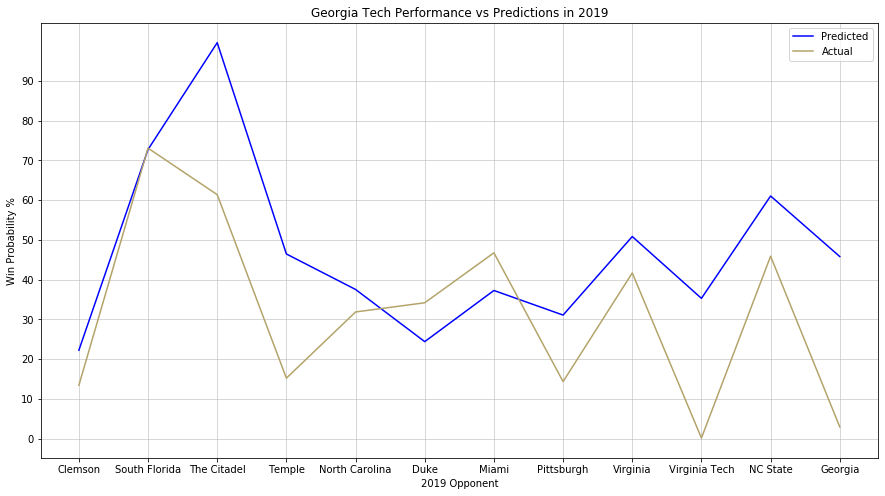

In [942]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

In [943]:
generate_win_prob(401112511, 2019)
# pbp_data[(pbp_data.year == 2019) & (pbp_data.offense == "Georgia Tech") & (pbp_data.defense == "Virginia Tech") & (pbp_data.play_type.isin(st_types))]

Game: Virginia Tech @ Georgia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 45.0
Proj MOV: Virginia Tech by 55.0 (exact value: 54.602474310591816)
Z score: 2.969721679355359
Win Prob for Virginia Tech: 99.85%
---


[0.9985096516677412, 45.0]

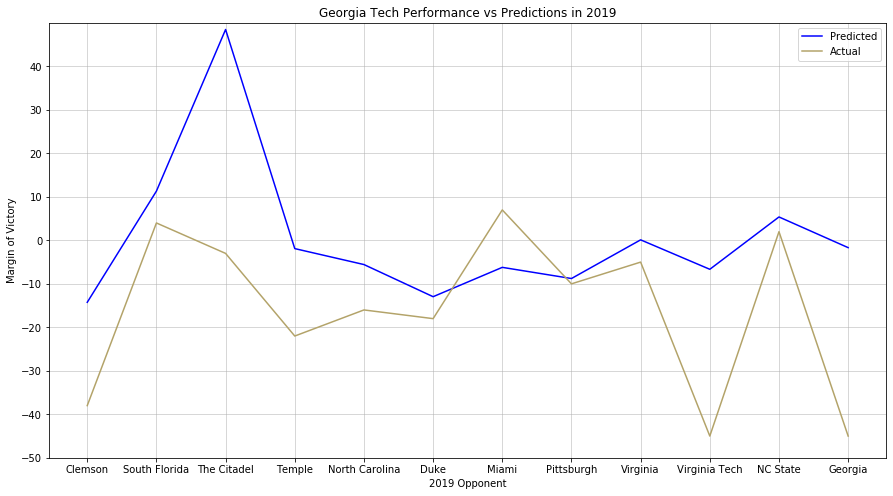

In [944]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 40.0 (exact value: 40.00823642970306)
Z score: 2.1721672008113257
Win Prob for Georgia Tech: 98.51%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by -3.0 (exact value: -2.6383805502138142)
Z score: -0.15841015750520207
Win Prob for South Florida: 43.71%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 4.0 (exact value: 3.562879207378987)
Z score: 0.1804799258721311
Win Prob for Pittsburgh: 57.16%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 39.0 (exact value: 39.09078995611261)
Z score: 2.122030047380746
Win Prob for Clemson: 98.31%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 37.0 (exact value: 36.64800368033846)
Z sc

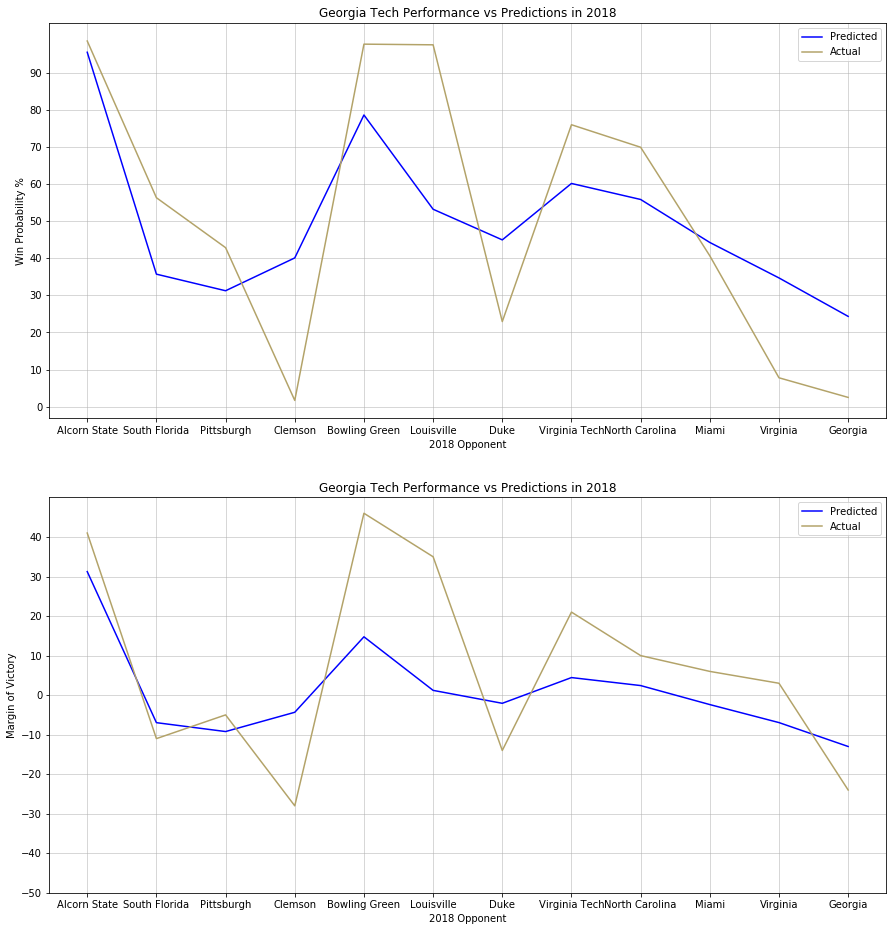

In [945]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

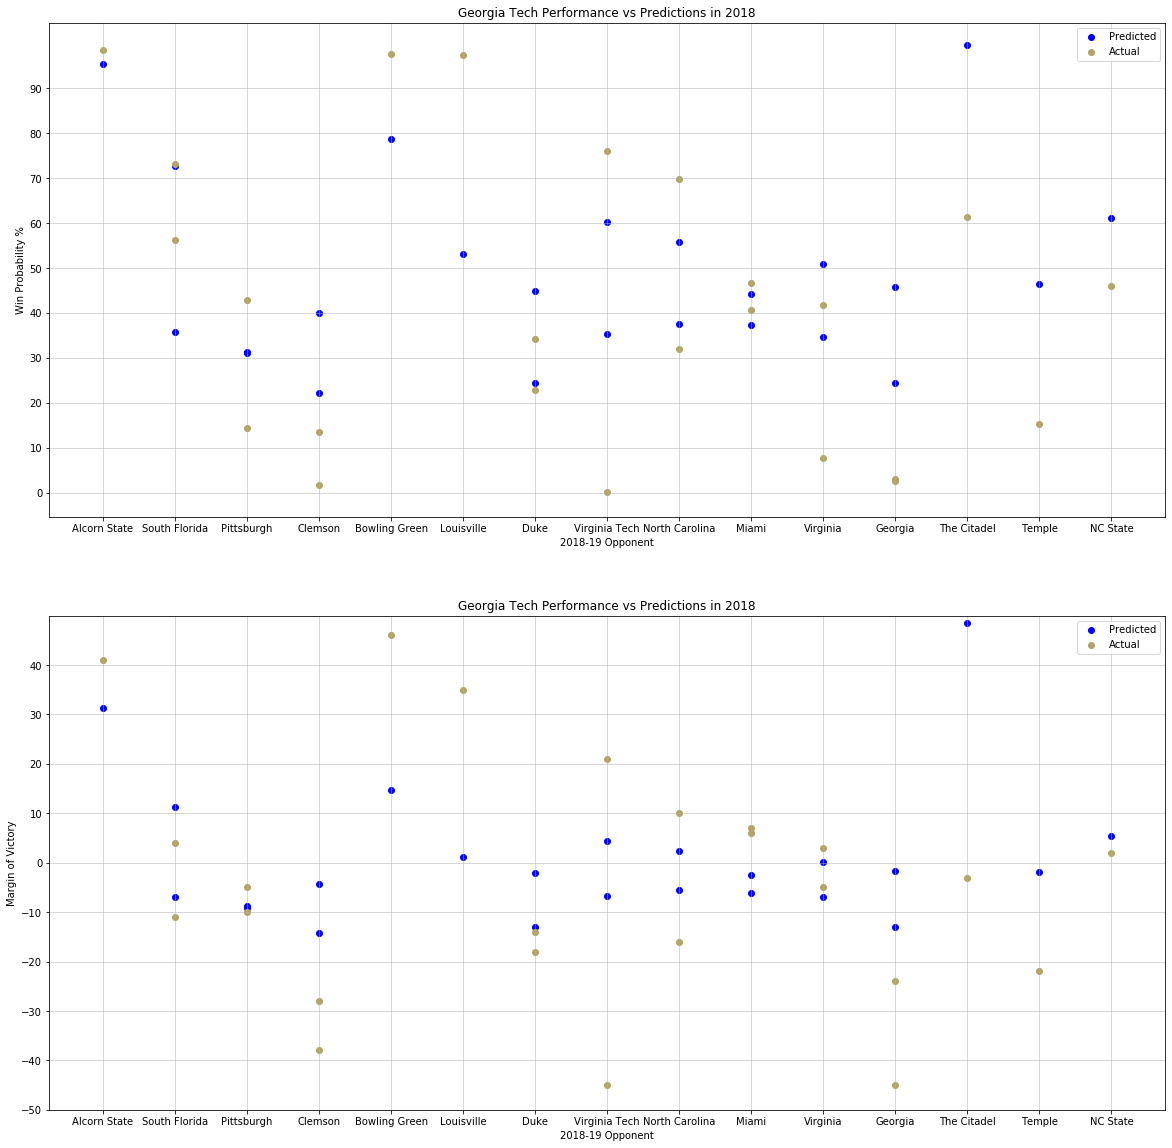

In [946]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [947]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season      2012      2013      2014      2015      2016      2017      2018  \
Season                                                                         
2012    1.000000  0.615224  0.411907  0.357465  0.287568  0.226592  0.206600   
2013    0.615224  1.000000  0.457896  0.301682  0.172773  0.224634  0.135255   
2014    0.411907  0.457896  1.000000  0.491099  0.320478  0.256464  0.273282   
2015    0.357465  0.301682  0.491099  1.000000  0.542155  0.420819  0.295301   
2016    0.287568  0.172773  0.320478  0.542155  1.000000  0.444357  0.310982   
2017    0.226592  0.224634  0.256464  0.420819  0.444357  1.000000  0.566003   
2018    0.206600  0.135255  0.273282  0.295301  0.310982  0.566003  1.000000   
2019    0.320945  0.293560  0.265340  0.334029  0.432654  0.392641  0.465473   

Season      2019  
Season            
2012    0.320945  
2013    0.293560  
2014    0.265340  
2015    0.334029  
2016    0.432654  
2017    0.392641  
2018    0.465473  
2019    1.000000

In [948]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

Year            Team        Opponent  Site  PredWinProb    PredMOV
0   2020  North Carolina             UCF  Away    48.275123  -0.531090
1   2020  North Carolina          Auburn  Home    38.693361  -4.997270
2   2020  North Carolina   James Madison  Home    99.541700  47.943161
3   2020  North Carolina     Connecticut  Home    80.534420  16.013092
4   2020  North Carolina  Boston College  Away    59.906558   4.852012
5   2020  North Carolina            Duke  Away    58.563360   4.218837
6   2020  North Carolina           Miami  Away    49.578708   0.067083
7   2020  North Carolina    Georgia Tech  Home    63.699262   6.672781
8   2020  North Carolina        NC State  Home    63.432130   6.542655
9   2020  North Carolina      Pittsburgh  Home    50.574420   0.523810
10  2020  North Carolina   Virginia Tech  Home    53.154637   1.708809
11  2020  North Carolina        Virginia  Away    52.921904   1.601748

In [949]:
generate_win_prob(401135288, 2019)
box2 = calculate_box_score(401135288, 2019)
# testDiffs = ["Team",'5FRDiff']
# print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API
Game: Oregon @ Wisconsin
Actual Winner: Oregon
MOV: Oregon by 1
Proj MOV: Oregon by 0.0 (exact value: 0.3102355612420157)
Z score: 0.002727546593634873
Win Prob for Oregon: 50.11%
---
Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API


Team       Eff      Expl   FinDrv    FldPos   Trnovr       5FR  \
0     Oregon  5.114379  4.961943  4.87236  4.830751  5.13668  5.006213   
1  Wisconsin  4.885621  5.038057  5.12764  5.315568  4.67132  4.989219   

    5FRDiff  
0  0.016993  
1 -0.016993

In [950]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

[0.49197875668087443, -0.10761928261641783]

In [951]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [952]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [953]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 535 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 530 games with betting lines for 2013 season.
[Simulation] Creating projections for 530 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 528 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 488 games with betting lines for 2014 season.
[Simulation] Creating projections for 488 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 570 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 542 games with betting lines for 2015 season.
[Simulation] Creating projections for 542 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

pick_category  season    W    L   D    WinPct
0            ML    2013  395  135   0  0.745283
1           ATS    2013  300  223   7  0.566038
0            ML    2014  372  116   0  0.762295
1           ATS    2014  305  174   9  0.625000
0            ML    2015  426  116   0  0.785978
1           ATS    2015  337  191  14  0.621771
0            ML    2016  422  117   0  0.782931
1           ATS    2016  336  189  14  0.623377
0            ML    2017  455  150   0  0.752066
1           ATS    2017  336  251  18  0.555372
0            ML    2018  408  127   0  0.762617
1           ATS    2018  303  216  16  0.566355
0            ML    2019  472  122   0  0.794613
1           ATS    2019  349  235  10  0.587542

In [954]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2019) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2019) if betting $5 per game: $3195.0


pick_category  season    W    L   D    WinPct  total_invested  net_payout  \
1           ATS    2013  300  223   7  0.566038            2650       273.5   
1           ATS    2014  305  174   9  0.625000            2440       568.0   
1           ATS    2015  337  191  14  0.621771            2710       634.5   
1           ATS    2016  336  189  14  0.623377            2695       640.5   
1           ATS    2017  336  251  18  0.555372            3025       299.5   
1           ATS    2018  303  216  16  0.566355            2675       327.0   
1           ATS    2019  349  235  10  0.587542            2970       452.5   

   avg_weekly_payout  pct_return  
1          17.093750    0.103208  
1          35.500000    0.232787  
1          42.300000    0.234133  
1          42.700000    0.237662  
1          19.966667    0.099008  
1          21.800000    0.122243  
1          30.166667    0.152357

In [955]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7693975782455489
Avg ATS Win %: 0.5922078150704724


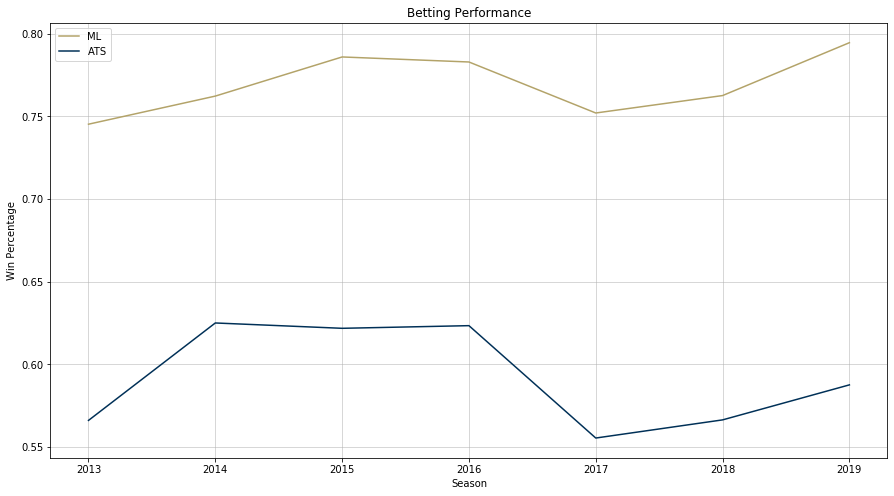

In [956]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

# import plotly.graph_objects as go

# # fg = px.line(historic_validation, x="season", y="WinPct", color='pick_category')
# # fg.show()

# fg = go.Figure()
# fg.add_trace(go.Scatter(x=historic_validation[(historic_validation.pick_category == "ML")].season, y=historic_validation[(historic_validation.pick_category == "ML")].WinPct * 100,
#                     mode='lines+markers',
#                     name='ML', line=dict(color='#b3a369')))
# fg.add_trace(go.Scatter(x=historic_validation[(historic_validation.pick_category == "ATS")].season, y=historic_validation[(historic_validation.pick_category == "ATS")].WinPct * 100,
#                     mode='lines+markers',
#                     name='ATS', line=dict(color='#003057')))
# fg.layout.xaxis.title = "Season"
# fg.layout.yaxis.title = "Win Percentage"
# fg.layout.title = "Betting Performance"

# fg.show()


In [957]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [958]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.6982277304120964, 9.763041969575411]

In [959]:
generate_win_prob(401135295, 2019)

Could not find basic game data for game_id 401135295 locally, checking CFB Data API
Could not find drive data for game_id 401135295 locally, checking CFB Data API
Could not find play by play data for game_id 401135295 locally, checking CFB Data API
Game: Clemson @ LSU
Actual Winner: LSU
MOV: LSU by 17
Proj MOV: LSU by 16.0 (exact value: 15.682853378819908)
Z score: 0.842819388827497
Win Prob for LSU: 80.03%
---


[0.8003352686960853, 17]

In [960]:
# Rankings data

rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

Rankings imported: 11864


In [961]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2019)
gen_srs

Team    5FRSRS  5FRSRSRank
53                     LSU  0.594718           1
77              Ohio State  0.363987           2
2                  Alabama  0.300470           3
78                Oklahoma  0.183750           4
34                 Georgia -0.006133           5
21                 Clemson -0.037120           6
9                   Auburn -0.039901           7
82                  Oregon -0.100575           8
115                   Utah -0.115919           9
29                 Florida -0.165507          10
59                Michigan -0.203479          11
84              Penn State -0.221796          12
128              Wisconsin -0.225585          13
102              Texas A&M -0.257996          14
62               Minnesota -0.306660          15
11                  Baylor -0.322152          16
65                    Navy -0.368314          17
56                 Memphis -0.378359          18
101                  Texas -0.417256          19
75              Notre Dame -0.440936          20
43              Iowa State -0.452781          21
98                     TCU -0.457066          22
0                Air Force -0.465014          23
110                    UCF -0.520352          24
123             Washington -0.553912          25
79          Oklahoma State -0.567037          26
71          North Carolina -0.623867          27
124       Washington State -0.627824          28
60          Michigan State -0.629747          29
57                   Miami -0.634789          30
..                     ...       ...         ...
28        Eastern Michigan -1.362785         101
22        Coastal Carolina -1.376745         102
31   Florida International -1.383507         103
61        Middle Tennessee -1.388273         104
7           Arkansas State -1.402460         105
72       Northern Illinois -1.405505         106
48                 Liberty -1.448491         107
116             Utah State -1.454870         108
95           South Florida -1.457686         109
105                 Toledo -1.539530         110
36           Georgia State -1.541208         111
73             North Texas -1.562648         112
87                    Rice -1.566656         113
118         UT San Antonio -1.566684         114
92           South Alabama -1.572212         115
68                  Nevada -1.596887         116
69              New Mexico -1.648568         117
58              Miami (OH) -1.652827         118
27           East Carolina -1.659230         119
88                 Rutgers -1.720647         120
113                   UNLV -1.721205         121
55                Maryland -1.765272         122
103            Texas State -1.779846         123
80            Old Dominion -1.860079         124
70        New Mexico State -1.864236         125
117                   UTEP -1.912695         126
14           Bowling Green -1.968244         127
25             Connecticut -2.030047         128
1                    Akron -2.283473         129
112                  UMass -2.803175         130

[130 rows x 3 columns]

In [962]:
# def adjust_rating(row):
#     # adjust by opps, conf
#     # figure out how much better or worse the team's schedule was than average
#     # figure out how much better or worse the team's schedule was than its conference's schedules
#     natl_avg = org_tmp[(org_tmp.Season == row.Season)]['5FRDiff'].mean()
#     opps = opponent_game_ids[(opponent_game_ids.Team == row.Team) & (opponent_game_ids.Season == row.Season)].Opponent.to_list()
#     opp_avg = org_tmp[(org_tmp.Season == row.Season) & (org_tmp.Team.isin(opps))]['5FRDiff'].mean()
#     team_conf = teams[(teams.school == row.Team)].conference.to_list()
#     opp_conf_avg = natl_avg
#     if (len(team_conf) > 0):
#         opp_conf = teams[(teams.conference.isin(team_conf))].school.to_list()
#         opp_conf_avg = org_tmp[(org_tmp.Season == row.Season) & (org_tmp.Team.isin(opp_conf))]['5FRDiff'].mean()
    
#     opp_diff = (opp_avg - natl_avg) / natl_avg
#     conf_diff = (opp_conf_avg - natl_avg) / natl_avg
    
#     return row['5FRDiff'] * opp_diff * conf_diff
    

# org_tmp['Adj5FRDiff'] = org_tmp.apply(lambda x: adjust_rating(x), axis=1)
# org_tmp.sort_values(by='Adj5FRDiff', ascending=False)

In [963]:
org_team_strength = pd.DataFrame()
def retrieve_srs(x, srs_data):
    r = srs_data[(srs_data.Team == x.Team)]
    if len(r) == 0:
        return None
    return stringify_entry(r['5FRSRS'])
def retrieve_srs_rank(x, srs_data):
    r = srs_data[(srs_data.Team == x.Team)]
    if len(r) == 0:
        return None
    return stringify_entry(r['5FRSRSRank'])

for yr in range(2012, 2020):
    srs = create_srs_for_year(yr)
    retrieve = org_tmp[org_tmp.Season == yr].copy()
    retrieve['5FRRank'] = range(1, len(retrieve)+1)
    max_week = rank_data[rank_data.season == yr].week.max()
    retrieve['5FRSRS'] = retrieve.apply(lambda x: retrieve_srs(x, srs), axis=1)
    retrieve['5FRSRSRank'] = retrieve.apply(lambda x: retrieve_srs_rank(x, srs), axis=1)
    retrieve['AP'] = retrieve.apply(lambda x: retrieve_rank(x, "AP",max_week), axis=1)
    retrieve['Coaches'] = retrieve.apply(lambda x: retrieve_rank(x, "Coaches",max_week), axis=1)
    retrieve['BCS/CFP'] = retrieve.apply(lambda x: retrieve_rank(x, "BCS/CFP",max_week), axis=1)
    org_team_strength = org_team_strength.append(retrieve)
print(org_team_strength[org_team_strength['5FRSRS'].isna() == True])    

org_team_strength['5FRPerf'] = model.predict(org_team_strength['5FRSRS'][:,np.newaxis]) 
org_team_strength['5FRRank'] = org_team_strength['5FRRank'].apply(lambda y: None if (y > 25) else y)
org_team_strength['5FRSRSRank'] = org_team_strength['5FRSRSRank'].apply(lambda y: None if (y > 25) else y)
org_team_strength

Empty DataFrame
Columns: [Team, Season, 5FRDiff, 5FRRank, 5FRSRS, 5FRSRSRank, AP, Coaches, BCS/CFP]
Index: []


Team  Season   5FRDiff  5FRRank    5FRSRS  5FRSRSRank  \
0         Florida State    2012  0.947195      1.0  0.404679         4.0   
1         Arizona State    2012  0.712300      2.0  0.478303         2.0   
2           Boise State    2012  0.619414      3.0  0.238145        10.0   
3               Alabama    2012  0.611200      4.0  0.557638         1.0   
4          Fresno State    2012  0.565929      5.0  0.285797         7.0   
5               Georgia    2012  0.530233      6.0  0.246678         9.0   
6              Oklahoma    2012  0.521827      7.0  0.392003         5.0   
7            Ohio State    2012  0.476085      8.0  0.105562        16.0   
8         Bowling Green    2012  0.447331      9.0 -0.394778         NaN   
9        Michigan State    2012  0.407122     10.0  0.074204        18.0   
10    Northern Illinois    2012  0.399027     11.0 -0.435950         NaN   
11           Notre Dame    2012  0.388579     12.0  0.448801         3.0   
12                Texas    2012  0.384017     13.0  0.235453        11.0   
13       North Carolina    2012  0.366376     14.0 -0.196676         NaN   
14           Utah State    2012  0.355985     15.0 -0.126602         NaN   
15                  BYU    2012  0.346134     16.0  0.114016        15.0   
16               Nevada    2012  0.343334     17.0 -0.013442         NaN   
17                 UCLA    2012  0.339715     18.0  0.181136        13.0   
18                Tulsa    2012  0.308421     19.0 -0.156569         NaN   
19              Clemson    2012  0.286321     20.0 -0.082686         NaN   
20    Appalachian State    2012  0.276358     21.0 -0.258427         NaN   
21            Wisconsin    2012  0.264979     22.0  0.042600        23.0   
22             Nebraska    2012  0.250910     23.0  0.056916        21.0   
23         Oregon State    2012  0.240662     24.0  0.247735         8.0   
24            Texas A&M    2012  0.236687     25.0  0.144689        14.0   
25               Oregon    2012  0.236083      NaN  0.321866         6.0   
26                  LSU    2012  0.228922      NaN  0.084185        17.0   
27           Penn State    2012  0.219252      NaN -0.188872         NaN   
28           Louisville    2012  0.216369      NaN -0.415938         NaN   
29         Kansas State    2012  0.202706      NaN -0.021016         NaN   
...                 ...     ...       ...      ...       ...         ...   
996          California    2019 -0.347341      NaN -1.131314         NaN   
997              Toledo    2019 -0.352653      NaN -1.539530         NaN   
998                UCLA    2019 -0.356275      NaN -1.111236         NaN   
999        Georgia Tech    2019 -0.361320      NaN -1.186723         NaN   
1000             Nevada    2019 -0.377239      NaN -1.596887         NaN   
1001            Arizona    2019 -0.378624      NaN -1.140250         NaN   
1002      Georgia State    2019 -0.388102      NaN -1.541208         NaN   
1003               Rice    2019 -0.413812      NaN -1.566656         NaN   
1004           Colorado    2019 -0.432972      NaN -1.099067         NaN   
1005     UT San Antonio    2019 -0.436006      NaN -1.566684         NaN   
1006         New Mexico    2019 -0.449196      NaN -1.648568         NaN   
1007               UTEP    2019 -0.487676      NaN -1.912695         NaN   
1008               UNLV    2019 -0.527954      NaN -1.721205         NaN   
1009         Utah State    2019 -0.533077      NaN -1.454870         NaN   
1010           Arkansas    2019 -0.537286      NaN -1.101680         NaN   
1011      West Virginia    2019 -0.573617      NaN -1.187889         NaN   
1012      East Carolina    2019 -0.582008      NaN -1.659230         NaN   
1013       Old Dominion    2019 -0.585034      NaN -1.860079         NaN   
1014         Miami (OH)    2019 -0.591749      NaN -1.652827         NaN   
1015             Kansas    2019 -0.599247      NaN -1.243479         NaN   
1016      South Florida    2019 -0.655871      NaN -1.457686       

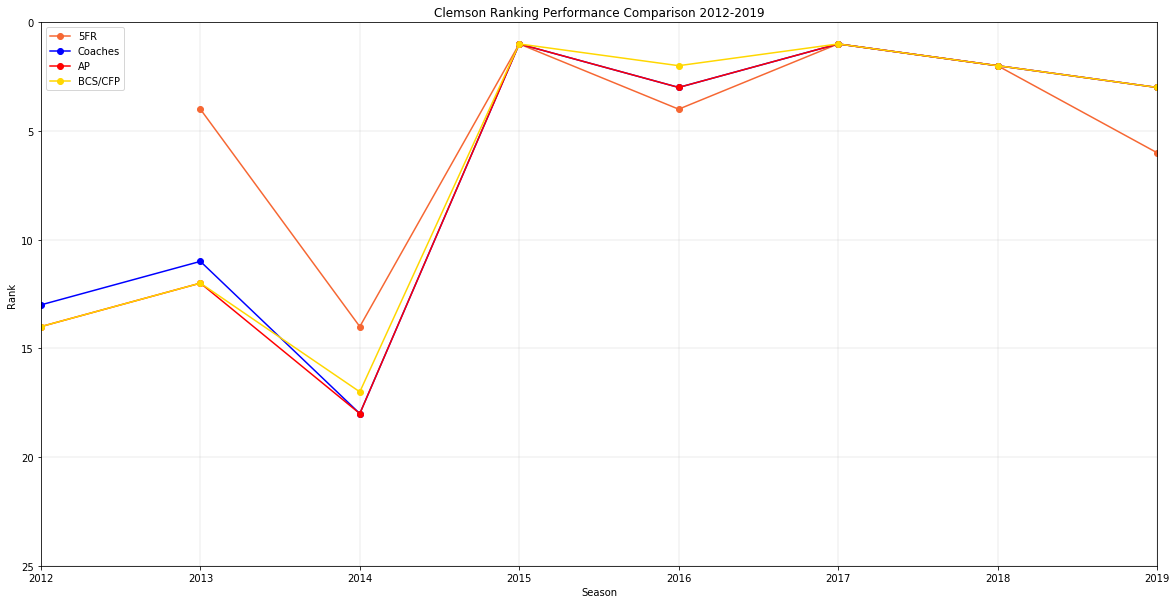

In [964]:
def retrieve_rankings_chart(team):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Rank')
    
    team_info = teams[teams.school == team]
    school_rankings = org_team_strength[(org_team_strength.Team == team)]
    ax.set_ylim((25, 0))
    ax.set_xlim((2012, 2019))
    ax.plot(school_rankings.Season, school_rankings['5FRSRSRank'], color=stringify_entry(team_info.color),label="5FR", marker='o')
    ax.plot(school_rankings.Season, school_rankings.Coaches, color='b',label="Coaches", marker='o')
    ax.plot(school_rankings.Season, school_rankings.AP, color='red',label="AP", marker='o')
    ax.plot(school_rankings.Season, school_rankings['BCS/CFP'], color='gold',label="BCS/CFP", marker='o')
    ax.set_title(f"{team} Ranking Performance Comparison {school_rankings.Season.min()}-{school_rankings.Season.max()}")
    ax.legend()
    return ax
retrieve_rankings_chart("Clemson");

In [965]:
eqmin = pbp_data.EqPPP.min()
eqmax = pbp_data.EqPPP.max()

exp_to_diff = stored_game_boxes.apply(lambda x: translate(x.IsoPPPDiff,eqmin-eqmax,eqmax-eqmin,0,10), axis=1)
act_to_diff = stored_game_boxes.apply(lambda x: create_expl_index(x), axis=1)

tester_df = pd.DataFrame({"Actual":act_to_diff, "Exp":exp_to_diff, "Pts":stored_game_boxes.PtsDiff})
tester_df.corr()

Actual       Exp       Pts
Actual  1.000000  0.685212  0.711130
Exp     0.685212  1.000000  0.230381
Pts     0.711130  0.230381  1.000000